In [1]:
import os
import logging
from pathlib import Path
import datetime
import xml.etree.ElementTree as ET

from tqdm import tqdm
import numpy as np
import math
import pandas as pd
import random

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torchvision.models import mobilenet_v3_small

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt

import torch.nn as nn 
from torch.nn.utils import parameters_to_vector
import torch.optim as optim

import torchmetrics

import cv2

In [2]:
#torch.cuda.empty_cache()

# Logger

In [3]:
log_path = 'results/'

logger = logging.getLogger("GonLogger")
logger.propagate = False
logger.setLevel(logging.INFO)
file_handler = logging.FileHandler(log_path + 'logfile.log')
formatter = logging.Formatter('%(message)s')
file_handler.setFormatter(formatter)

# add file handler to logger
logger.addHandler(file_handler)

logger.info('MOBILENET Classifier. First Test.')

# Config

In [4]:
CLASSES = ["smoke", "fire"]
N_CLASSES = len(CLASSES)

IMG_DIM = {'W':224, 'H':224} # (W, H)
IMG_H = IMG_DIM['H']
IMG_W = IMG_DIM['W']

# Dataset

# DFire

In [5]:
class DFireDataset(Dataset):
    '''
    Creates a Pytorch Dataset to train the Yolov1 Network.
    Encodes labels to match the format [xcell, ycell, w, h, confidence, class_0 (smoke), class_1 (fire)]
        - Final encoding format is: [xcell, ycell, w, h, conf=1, smoke?, fire?]

    Discard images when there are more than 1 object in the same cell
    
    Arguments:
        - img_h:            image height
        - img_w:            image width
        - img_dir:          path to images folder
        - label_dir:        path to labels folder
        - num_classes:      number of classes
        - transform:        transformation applied to input images -> Albumentations
        - target_transform: transformation applied to labels -> nothing by default

    Return:
        - img:              1 image of the dataset
        - target:           corresponding label encoded: [smoke, fire]
    '''

    def __init__(self, img_h, img_w, img_dir, label_dir, num_classes,
                 ds_len,
                 transform=None, target_transform=None):
        self.img_h = img_h
        self.img_w = img_w
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.num_classes = num_classes
        self.ds_len = ds_len
        self.transform = transform
        self.target_transform = target_transform
        
        self.except_transform = A.Compose([
                                    A.Resize(self.img_h, self.img_w, p=1),
                                    ToTensorV2(p=1),
                                    ]
                                )

        self.labels_list = sorted(
            [
                os.path.join(self.label_dir, file_name)
                for file_name in os.listdir(self.label_dir)
                if file_name.endswith(".txt")
            ]
        )
    
        if ds_len is not None:
            random.seed(123)
            random.shuffle(self.labels_list)
            self.images_path, self.labels = self.__build_ds__(self.labels_list[:self.ds_len])
            self.num_samples = len(self.labels_list[:self.ds_len])
        else:
            self.images_path, self.labels = self.__build_ds__(self.labels_list)
            self.num_samples = len(self.labels_list)

    def __len__(self):
        return self.num_samples   

    def __build_ds__(self, labels_list):
        labels = []
        images = []
        wrong_imgs = 0
        empty = 0
        only_smoke = 0
        only_fire = 0
        smoke_fire = 0
                
        for label in labels_list:
            fname = Path(label).stem
            image_path = self.img_dir + fname + '.jpg'   
            #print(fname, image_path)
                                   
            if cv2.imread(image_path) is None:
                print(f'{image_path} cannot be read by cv2 -> removed')
                wrong_imgs += 1
            
            else:
                
                label_array = np.zeros((self.num_classes))
            
                with open(label) as f:
                    lines = f.readlines()
                       
                    for line in lines:
                        class_id, _, _, _, _ = line.strip().split()
                        class_id = int(class_id)
                        if np.array_equal(label_array, np.array([1, 1])):
                            break
                        else:
                            label_array[class_id] = 1.

                    if np.array_equal(label_array, np.array([1, 1])):
                        smoke_fire += 1
                    elif np.array_equal(label_array, np.array([0, 1])):
                        only_fire += 1
                    elif np.array_equal(label_array, np.array([1, 0])):
                        only_smoke += 1
                    elif np.array_equal(label_array, np.array([0, 0])):
                        empty += 1
                    else:
                        print("Wrong label in DFire dataset")
                        logger.info("Wrong label in DFire dataset")
                        
                    labels.append(label_array)
                    images.append(image_path)
        
        print(f'DFire Removed wrong images: {wrong_imgs}')
        logger.info(f'DFire Removed wrong images: {wrong_imgs}')
        print(f'DFire empty images: {empty}')
        logger.info(f'DFire empty images: {empty}')
        print(f'DFire only smoke images: {only_smoke}')
        logger.info(f'DFire only smoke images: {only_smoke}')
        print(f'DFire only fire images: {only_fire}')
        logger.info(f'DFire only fire images: {only_fire}')
        print(f'DFire smoke and fire images: {smoke_fire}')
        logger.info(f'DFire smoke and fire images: {smoke_fire}')

        labels_np = np.array(labels)
        labels_tensor = torch.tensor(labels_np, dtype=torch.float32)
        images_array = np.array(images)
        
        return images_array, labels_tensor

    def __getitem__(self, index):

        # Image processing
        img_file = self.images_path[index]
        img = cv2.imread(img_file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   

        # Labels processing
        label = self.labels[index]
        
        # Data Augmentation
        if self.transform is not None:
            try:
                aug = self.transform(image=img)
                img = aug['image'] / 255.0
            except:
                #print(f'Error trying to augment image {img_file}')
                aug = self.except_transform(image=img)
                img = aug['image'] / 255.0
        
        return img, label

### View Dataset

In [6]:
ds_dir = '../../../datasets/ds2fire/dfire_yolo/'

train_dir = ds_dir + 'train/'
train_imgs = train_dir + 'images/'
train_labels = train_dir + 'labels/'

#val_dir = ds_dir + 'test/'

val_dir = ds_dir + 'test/'
val_imgs = val_dir + 'images/'
val_labels = val_dir + 'labels/'

print(f'Train dir: {os.listdir(train_dir)}')
print(f'val dir: {os.listdir(val_dir)}')

Train dir: ['labels', '.ipynb_checkpoints', 'images']
val dir: ['labels', '.ipynb_checkpoints', 'images']


### Transform

In [7]:
view_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.4),
            A.HueSaturationValue(hue_shift_limit=10, p=0.2),
            A.Blur(blur_limit=(3,3), p=0.3),
            A.CLAHE(clip_limit=2.0, p=0.3),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        ], p=0.9),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.Resize(IMG_H, IMG_W, p=1),
        ToTensorV2(p=1),
    ]
)

In [8]:
VIEW_BATCH_SIZE = 32

view_dfire_ds = DFireDataset(img_h=IMG_H, 
                             img_w=IMG_W, 
                             img_dir=val_imgs, 
                             label_dir=val_labels, 
                             num_classes=N_CLASSES,
                             ds_len=2*VIEW_BATCH_SIZE,
                             transform=view_transform)

view_loader = DataLoader(dataset=view_dfire_ds,
                         batch_size=VIEW_BATCH_SIZE,
                         num_workers=1,
                         pin_memory=True,
                         shuffle=True,
                         drop_last=False)
print(f'Val dataset length: {len(view_dfire_ds)}')

DFire Removed wrong images: 0
DFire empty images: 31
DFire only smoke images: 17
DFire only fire images: 2
DFire smoke and fire images: 14
Val dataset length: 64


# Plot Dataset Pictures

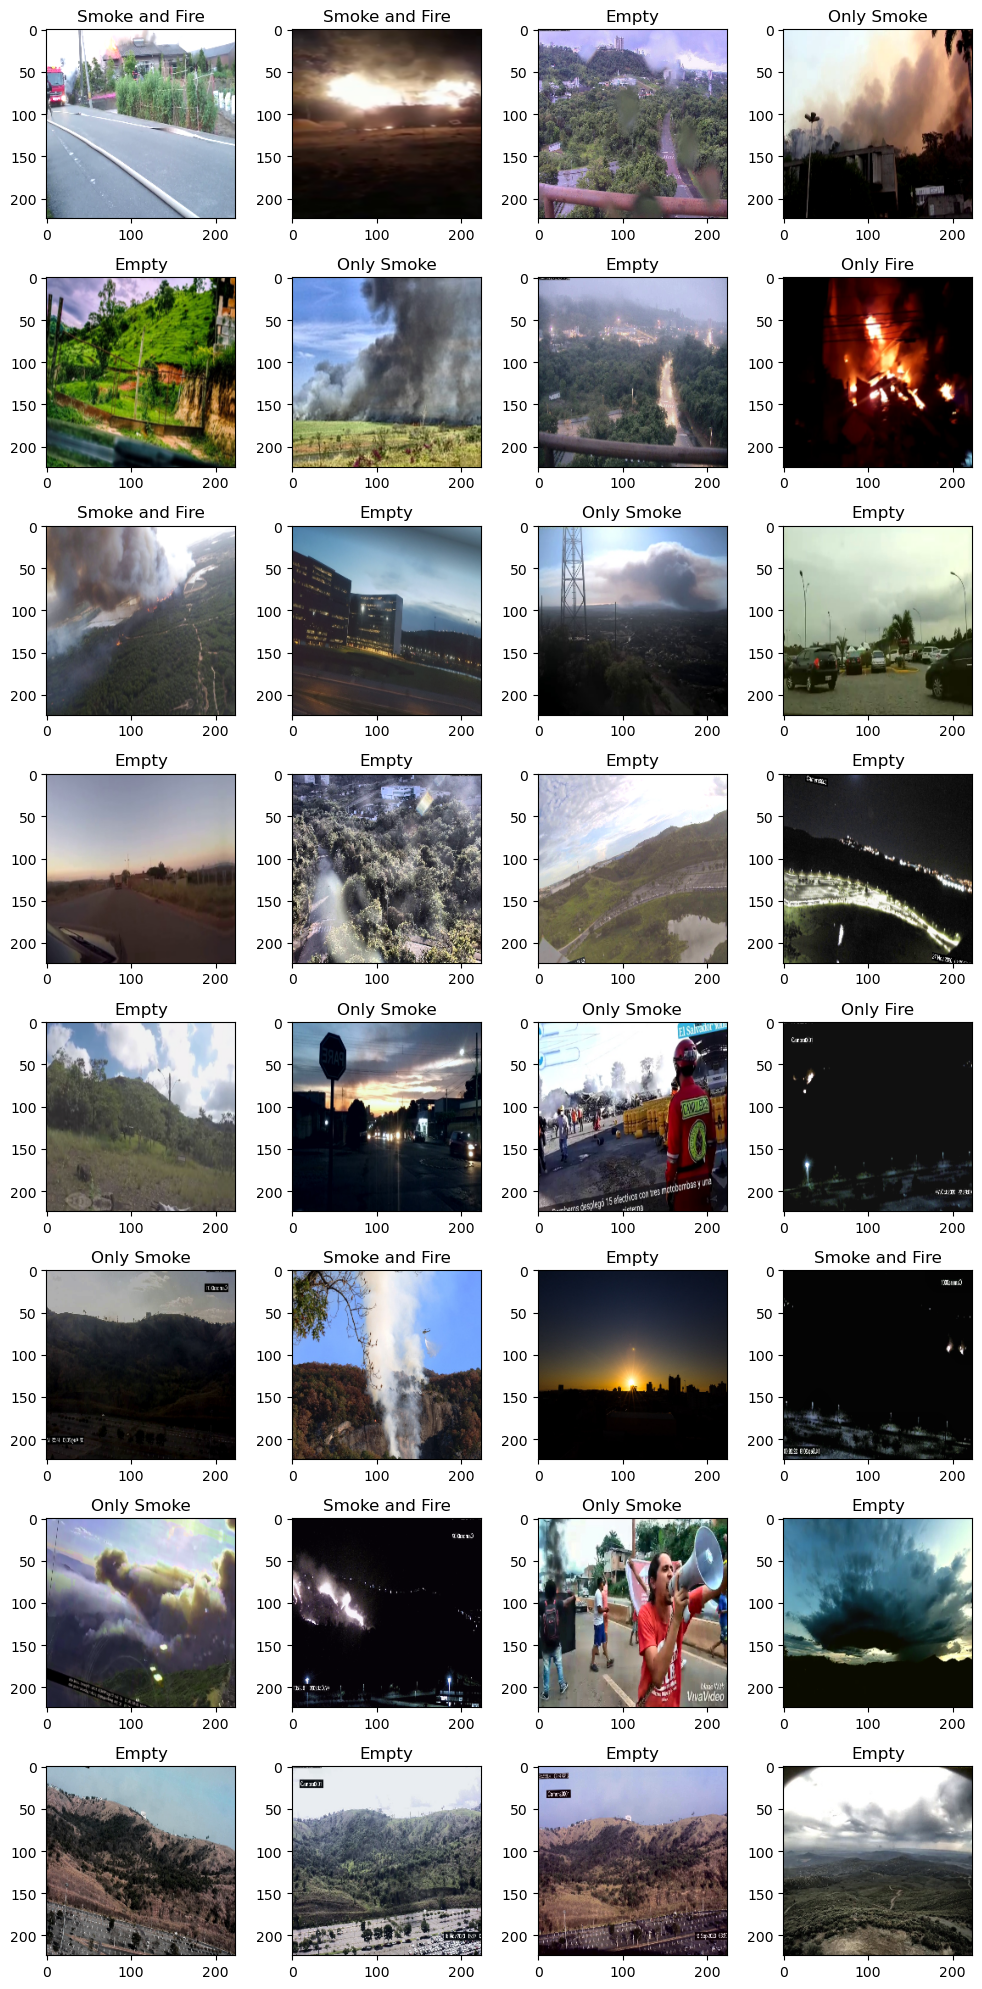

In [9]:
for i, (img, label) in enumerate(view_loader):

    plt.subplots(8,4, figsize=(10, 20))
    
    for idx in range(VIEW_BATCH_SIZE):
        plt.subplot(8, 4, idx+1)
        plt.imshow(img[idx].permute(1, 2, 0))
        title = ""
        if label[idx][0] == 1 and label[idx][1] == 1:
            title += "Smoke and Fire"
        elif label[idx][0] == 1 and label[idx][1] == 0:
            title += "Only Smoke"
        elif label[idx][0] == 0 and label[idx][1] == 1:
            title += "Only Fire"
        else:
            title += "Empty"
        plt.title(title)
        
        if (idx == 31):
            break
    plt.tight_layout()
    plt.show()
    break

# Model: MOBILENET Pretrained

In [10]:
class PRETRAINED_MOBILENET(nn.Module):
    def __init__(self, base_model, last_channels, num_classes, in_channels=3):
        super().__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.last_channels = last_channels
        
        self.base_model = nn.Sequential(*list(base_model.children())[:-1])

        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.smoke = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=self.last_channels, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=1)
        )
        self.fire = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=self.last_channels, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=1)
        )

    # TODO: initizalize only head layers
    # def _initialize_weights(self):
    #     for m in self.modules():
    #         if isinstance(m, nn.Conv2d):
    #             nn.init.kaiming_normal_(m.weight, mode='fan_in',
    #                 nonlinearity='relu'
    #             )
    #             if m.bias is not None:
    #                     nn.init.constant_(m.bias, 0)
    #         elif isinstance(m, nn.Linear):
    #             nn.init.normal_(m.weight, 0, 0.01)
    #             nn.init.constant_(m.bias, 0)

    # [xc1, yc1, w1, h1, conf1, xc2, yc2, w2, h2, conf2, smoke, fire]
    # [0 ................. 4,    5 ................ 9      10    11 ]
    
    def forward(self, x):
        x = self.base_model(x)
        x = self.pool(x)
        x = torch.flatten(x, start_dim=1)
        x = torch.cat((self.smoke(x), self.fire(x)), dim=-1)
        #x = torch.sigmoid(x) # BCE Logits
        return x

# Loss

In [11]:
class BCE_LOSS(nn.Module):
    '''
    dataset output: (image, {smoke: x, fire: x})
    model output: {smoke: x, fire: x}
    '''

    def __init__(self, device):
        super(BCE_LOSS, self).__init__()
        self.device = device
        #self.bce = nn.BCELoss(reduction='mean')
        self.bce = nn.BCEWithLogitsLoss(reduction='sum')
        self.mse = nn.MSELoss(reduction='sum')
        
        self.eps = 1e-10
        
        self.smoke_loss = 0
        self.fire_loss = 0

    def forward(self, ground_truth, predictions):
        
        # print(f'Ground trunth: {ground_truth}')
        # print(f'Predictions: {predictions}')
        
        # BCELoss: ALWAYS (prediction, target) -> it crashes with NaN if order is wrong
        smoke_loss = self.bce(predictions[..., 0],
                              ground_truth[..., 0])
        self.smoke_loss = smoke_loss.item()
        fire_loss = self.bce(predictions[..., 1],
                             ground_truth[..., 1])
        self.fire_loss = fire_loss.item()
        
        total_loss = smoke_loss + fire_loss
        
        return total_loss

    def get_last_losses(self):     
        return {
            'smoke_loss': self.smoke_loss,
            'fire_loss': self.fire_loss,
        }

# Hyperparameters

In [12]:
''' ============================
    Hyperparameters and More
============================ '''

#MODEL = "BED"
MODEL = "MOBILENETV3"

#LEARNING_RATE = 5e-4
LEARNING_RATE = 0.001
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 64 
WEIGHT_DECAY = 1e-3
EPOCHS = 20 #100
NUM_WORKERS = 8
PIN_MEMORY = True
PRETRAINED = True
LOAD_MODEL = False
if MODEL == "BED":
    LOAD_MODEL_FILE = log_path + "bed_classifier_best.pt"
elif MODEL == "SQUEEZE":
    #LOAD_MODEL_FILE = log_path + "squeeze_classifier_best.pt"
    LOAD_MODEL_FILE = "squeezeNet/" + "SQUEEZE_best_classifier.pt"

LOSS_FN = "BCE"

TRAIN_IMG_DIR = train_imgs
TRAIN_LABEL_DIR = train_labels
VAL_IMG_DIR = val_imgs
VAL_LABEL_DIR = val_labels

LOG_FILE = "log_file.xlsx"

DS_LEN = None


''' ============================
    Metrics
============================ '''
# Loss output
## Train
train_total_loss = []
train_smoke_loss = []
train_fire_loss = []
## Val
val_total_loss = []
val_smoke_loss = []
val_fire_loss = []

# Accuracy, Precision, Recall, F1
## Train
train_smoke_total_accuracy = []
train_smoke_total_precision = []
train_smoke_total_recall = []
train_smoke_total_f1 = []
train_fire_total_accuracy = []
train_fire_total_precision = []
train_fire_total_recall = []
train_fire_total_f1 = []
## Val
val_smoke_total_accuracy = []
val_smoke_total_precision = []
val_smoke_total_recall = []
val_smoke_total_f1 = []
val_fire_total_accuracy = []
val_fire_total_precision = []
val_fire_total_recall = []
val_fire_total_f1 = []

epochs_plot = []

# Model Setup

In [14]:
''' ======================================
    SETUP: Model, Loss, Dataset, Loader
====================================== '''

def setup_model(pretrained, load, model_name):
    if pretrained == True:
        if model_name == "MOBILENETV3":
            print("Using MOBILENETV3 Classifier")
            logger.info("Using MOBILENETV3 Classifier")
        
            base_model = mobilenet_v3_small(weights='IMAGENET1K_V1')
            print(list(base_model.children())[-1])
            for name, layer in base_model.named_modules():
                if isinstance(layer, nn.Linear):
                    last_channels = layer.in_features
                    print(f'Model Pretrained has {last_channels} in features in last layer')
                    logger.info(f'Model Pretrained has {last_channels} in features in last layer')
            for param in base_model.parameters():
                param.requires_grad = False
            
            model = PRETRAINED_MOBILENET(base_model, last_channels=576, num_classes=N_CLASSES).to(DEVICE)   

            return model
    else:
        print("Wrong Model")
        logger.info("Wrong Model")
        raise SystemExit("Wrong Model")

model = setup_model(pretrained=PRETRAINED, load=LOAD_MODEL, model_name=MODEL)

# Check model shape
in_rand_np = np.random.rand(4, 3, IMG_H, IMG_W)
in_rand = torch.tensor(in_rand_np, dtype=torch.float32, device=DEVICE)
out_test = model(in_rand)
print(f'Model shape is {out_test}')
print(f'BED Model Arquitecture\n{model}')
logger.info(f'Model shape is {out_test}')
logger.info(f'BED Model Arquitecture\n{model}')


optimizer = optim.Adam(model.parameters(), 
                       lr=LEARNING_RATE, 
                       weight_decay=WEIGHT_DECAY)
# optimizer = torch.optim.SGD(model.parameters(), 
#                             lr=LEARNING_RATE,
#                             momentum=0.9, 
#                             weight_decay=WEIGHT_DECAY, 
#                             nesterov=True)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                 mode='min',
                                                 factor=0.8, 
                                                 patience=2, 
                                                 threshold=0.001, 
                                                 threshold_mode='abs',
                                                 min_lr=1e-6)

# MODEL PARAMETERS
n_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'\nTrainable parameters = {n_trainable}')
logger.info(f'\nTrainable parameters = {n_trainable}')

n_params = parameters_to_vector(model.parameters()).numel()
print(f'Total parameters = {n_params}\n')
logger.info(f'Total parameters = {n_params}\n')

Using MOBILENETV3 Classifier
Sequential(
  (0): Linear(in_features=576, out_features=1024, bias=True)
  (1): Hardswish()
  (2): Dropout(p=0.2, inplace=True)
  (3): Linear(in_features=1024, out_features=1000, bias=True)
)
Model Pretrained has 576 in features in last layer
Model Pretrained has 1024 in features in last layer
Model shape is tensor([[-0.3554,  0.0205],
        [-0.2512, -0.0077],
        [-0.4028, -0.0724],
        [-0.3376, -0.1301]], device='cuda:0', grad_fn=<CatBackward0>)
BED Model Arquitecture
PRETRAINED_MOBILENET(
  (base_model): Sequential(
    (0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), p

# Metrics

In [15]:
precision_metric = torchmetrics.classification.MultilabelPrecision(num_labels = N_CLASSES, 
                                                                   threshold = 0.5, 
                                                                   average = None).to(DEVICE)
recall_metric = torchmetrics.classification.MultilabelRecall(num_labels = N_CLASSES, 
                                                             threshold = 0.5, 
                                                             average = None).to(DEVICE)
accuracy_metric = torchmetrics.classification.MultilabelAccuracy(num_labels = N_CLASSES, 
                                                                 threshold = 0.5, 
                                                                 average = None).to(DEVICE)
f1_metric = torchmetrics.classification.MultilabelF1Score(num_labels = N_CLASSES, 
                                                          threshold = 0.5, 
                                                          average = None).to(DEVICE)

# Train Loop

In [16]:
'''
Train function
'''
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def train_fn(loader, model, optimizer, loss_fn, device):
    
    print(f'Learning Rate = {get_lr(optimizer=optimizer)}\n')
    logger.info(f'Learning Rate = {get_lr(optimizer=optimizer)}')

    model.train()
    loop = tqdm(loader, desc='Training', leave=True)
    train_losses = []
    smoke_losses = []
    fire_losses = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(device), y.to(device)
        out = model(x)
        train_loss = loss_fn(ground_truth=y, 
                             predictions=out)
      
        # Gradient Descent
        optimizer.zero_grad()
        train_loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
        optimizer.step()

        # BCE Loss
        last_losses = loss_fn.get_last_losses()
        train_losses.append(train_loss.item())
        smoke_losses.append(last_losses['smoke_loss'])
        fire_losses.append(last_losses['fire_loss'])
        
        # print(f'Train loss: {train_loss}')
        # print(f'Train loss: {train_losses}')
        
        model.eval()
        # Metrics -> Maybe change to metric.update(), sin hacer precision = ...
        yhat = torch.sigmoid(out.detach())
        precision_metric.update(yhat, y)
        recall = recall_metric.update(yhat, y)
        accuracy = accuracy_metric.update(yhat, y)
        f1 = f1_metric.update(yhat, y)
        model.train()
    
    model.eval()
    precision = precision_metric.compute()
    recall = recall_metric.compute()
    accuracy = accuracy_metric.compute()
    f1 = f1_metric.compute()
    model.train()
        
    logger.info("\nTRAIN losses")
    train_mean_loss = sum(train_losses)/len(train_losses)
    smoke_mean_loss = sum(smoke_losses)/len(smoke_losses)
    fire_mean_loss = sum(fire_losses)/len(fire_losses)


    print("Total Loss".ljust(12) + "|" + 
          "Smoke Loss".ljust(12) + "|" + 
          "Fire Loss".ljust(12))
    print("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    print(f'{train_mean_loss:.3f}'.ljust(12) + "|" +
          f'{smoke_mean_loss:.3f}'.ljust(12) + "|" +
          f'{fire_mean_loss:.3f}'.ljust(12) + "\n")
    
    logger.info("Total Loss".ljust(12) + "|" + 
          "Smoke Loss".ljust(12) + "|" + 
          "Fire Loss".ljust(12))
    logger.info("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    logger.info(f'{train_mean_loss:.3f}'.ljust(12) + "|" +
          f'{smoke_mean_loss:.3f}'.ljust(12) + "|" +
          f'{fire_mean_loss:.3f}'.ljust(12) + "\n")   
    
    precision_metric.reset()
    recall_metric.reset()
    accuracy_metric.reset()
    f1_metric.reset()
    
    return (train_mean_loss, 
            smoke_mean_loss, 
            fire_mean_loss,
            accuracy,
            precision,
            recall,
            f1)

# Validation Loop

In [17]:
'''
Evaluation Function
'''
def eval_fn(loader, model, loss_fn, device):
    
    model.eval()
    loop = tqdm(loader, desc='Validating', leave=True)
    val_losses = []
    smoke_losses = []
    fire_losses = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(device), y.to(device)
        out = model(x)
        val_loss = loss_fn(ground_truth=y, 
                           predictions=out)      
        
        # BCE Loss
        last_losses = loss_fn.get_last_losses()
        val_losses.append(val_loss.item())
        smoke_losses.append(last_losses['smoke_loss'])
        fire_losses.append(last_losses['fire_loss'])
    
        # Metrics -> Maybe change to metric.update(), sin hacer precision = ...
        yhat = torch.sigmoid(out.detach())
        precision_metric.update(yhat, y)
        recall = recall_metric.update(yhat, y)
        accuracy = accuracy_metric.update(yhat, y)
        f1 = f1_metric.update(yhat, y)
    
    precision = precision_metric.compute()
    recall = recall_metric.compute()
    accuracy = accuracy_metric.compute()
    f1 = f1_metric.compute()

    logger.info("\nVAL losses")
    val_mean_loss = sum(val_losses)/len(val_losses)
    smoke_mean_loss = sum(smoke_losses)/len(smoke_losses)
    fire_mean_loss = sum(fire_losses)/len(fire_losses)

    print("Total Loss".ljust(12) + "|" + 
          "Smoke Loss".ljust(12) + "|" + 
          "Fire Loss".ljust(12))
    print("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    print(f'{val_mean_loss:.3f}'.ljust(12) + "|" +
          f'{smoke_mean_loss:.3f}'.ljust(12) + "|" +
          f'{fire_mean_loss:.3f}'.ljust(12) + "\n")
    
    logger.info("Total Loss".ljust(12) + "|" + 
          "Smoke Loss".ljust(12) + "|" + 
          "Fire Loss".ljust(12))
    logger.info("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    logger.info(f'{val_mean_loss:.3f}'.ljust(12) + "|" +
          f'{smoke_mean_loss:.3f}'.ljust(12) + "|" +
          f'{fire_mean_loss:.3f}'.ljust(12) + "\n")   

    logger.info("VAL Metrics")
    print(f'SMOKE -> Precision: {precision[0]:.3f} - Recall: {recall[0]:.3f} - Accuracy: {accuracy[0]:.3f} - F1: {f1[0]:.3f}')
    logger.info(f'SMOKE -> Precision: {precision[0]:.3f} - Recall: {recall[0]:.3f} - Accuracy: {accuracy[0]:.3f} - F1: {f1[0]:.3f}')
    print(f'FIRE -> Precision: {precision[1]:.3f} - Recall: {recall[1]:.3f} - Accuracy: {accuracy[1]:.3f} - F1: {f1[1]:.3f}')
    logger.info(f'FIRE -> Precision: {precision[1]:.3f} - Recall: {recall[1]:.3f} - Accuracy: {accuracy[1]:.3f} - F1: {f1[1]:.3f}')
    
    precision_metric.reset()
    recall_metric.reset()
    accuracy_metric.reset()
    f1_metric.reset()
    
    return (val_mean_loss, 
            smoke_mean_loss, 
            fire_mean_loss,
            accuracy,
            precision,
            recall,
            f1)

# Dataset Setup

In [18]:
train_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.4),
            A.HueSaturationValue(hue_shift_limit=10, p=0.2),
            A.Blur(blur_limit=(3,3), p=0.3),
            A.CLAHE(clip_limit=2.0, p=0.3),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        ], p=0.9),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.Resize(IMG_H, IMG_W, p=1),
        ToTensorV2(p=1),
    ]
)

# TRAIN DATASET
print("\nTRAIN DFIRE dataset")
logger.info("\nTRAIN DFIRE dataset")
train_dataset = DFireDataset(img_h = IMG_H,
                             img_w = IMG_W,
                             img_dir = TRAIN_IMG_DIR,
                             label_dir = TRAIN_LABEL_DIR,
                             num_classes=N_CLASSES,
                             ds_len = DS_LEN,
                             transform=train_transform)

print(f'Train dataset len: {len(train_dataset)}')
logger.info(f'Train dataset len: {len(train_dataset)}')


# VALIDATION DATASET
val_transform = A.Compose([
    A.Resize(IMG_H, IMG_W, p=1),
    ToTensorV2(p=1),
    ]
)

print("\nTEST DFire dataset")
logger.info("\nTEST DFire dataset")
val_dataset = DFireDataset(img_h = IMG_H,
                           img_w = IMG_W,
                           img_dir = VAL_IMG_DIR,
                           label_dir = VAL_LABEL_DIR,
                           num_classes = N_CLASSES,
                           ds_len = DS_LEN,
                           transform=val_transform)

print(f'Test dataset len: {len(val_dataset)}')
logger.info(f'Test dataset len: {len(val_dataset)}')


# LOADERS
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=NUM_WORKERS,
                          pin_memory=PIN_MEMORY,
                          shuffle=True,
                          drop_last=True)

val_loader = DataLoader(dataset=val_dataset,
                        batch_size=BATCH_SIZE,
                        num_workers=NUM_WORKERS,
                        pin_memory=PIN_MEMORY,
                        shuffle=False,
                        drop_last=True)


TRAIN DFIRE dataset
DFire Removed wrong images: 0
DFire empty images: 7833
DFire only smoke images: 4681
DFire only fire images: 944
DFire smoke and fire images: 3763
Train dataset len: 17221

TEST DFire dataset
DFire Removed wrong images: 0
DFire empty images: 2005
DFire only smoke images: 1186
DFire only fire images: 220
DFire smoke and fire images: 895
Test dataset len: 4306


# Main Function

In [19]:
''' ============================
    Print Config Values
============================ '''
print(f'Device: {DEVICE}')
print(f'Learning Rate: {LEARNING_RATE}')
print(f'Weight Decay: {WEIGHT_DECAY}')
print(f'Batch Size: {BATCH_SIZE}')
print(f'IMG DIMS: ({IMG_H}, {IMG_W})')
print(f'W: {IMG_W}\nH: {IMG_H}')

logger.info(f'Device: {DEVICE}')
logger.info(f'Learning Rate: {LEARNING_RATE}')
logger.info(f'Weight Decay: {WEIGHT_DECAY}')
logger.info(f'Batch Size: {BATCH_SIZE}')
logger.info(f'IMG DIMS: ({IMG_H}, {IMG_W})')
logger.info(f'W: {IMG_W}\nH: {IMG_H}')

Device: cuda
Learning Rate: 0.001
Weight Decay: 0.001
Batch Size: 64
IMG DIMS: (224, 224)
W: 224
H: 224


## Loss Funtion Setup

In [20]:
# LOSS FUNCTION
if LOSS_FN == "BCE":
    print(f'Loss Function: BCE')
    logger.info(f'Loss Function: BCE')
    loss_fn = BCE_LOSS(device=DEVICE)
else:
    print("Wrong loss function")
    logger.info("Wrong loss function")
    raise SystemExit("Wrong loss function")

Loss Function: BCE


In [21]:
def train_model(model, model_name, optimizer, scheduler, first_epoch=0, epochs = EPOCHS):
   
    ''' ==============================================================
                                TRAINING LOOP
    ============================================================== '''
    # Start with infinite validation loss
    best_valid_loss = np.inf

    start = datetime.datetime.now()
    start_time = start.strftime("%H:%M:%S")
    print(f'\n***Start Training: {start_time}\n')
    logger.info(f'\n***Start Training: {start_time}\n')

    start_epoch = first_epoch

    if LOAD_MODEL == False:
        if model_name == "BED":
            model._initialize_weights()
            print("Initializing Weights")
            logger.info("Initializing Weights")
        elif model_name == "SQUEEZE":
            model._initialize_weights()
            print("Initializing Weights")
            logger.info("Initializing Weights")
        else: 
            print("Pretrained Weights")
            logger.info("Pretrained Weights")            
    else:
        checkpoint = torch.load(LOAD_MODEL_FILE)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch']
        print(f"Loading Model. Train from epoch: {start_epoch}")
        logger.info(f"Loading Model. Train from epoch: {start_epoch}")
        
    for epoch in range(start_epoch, start_epoch + epochs):

        print(f'\n=== EPOCH {epoch}/{start_epoch + epochs-1} ===')
        logger.info(f'\n=== EPOCH {epoch}/{start_epoch + epochs-1} ===')
        
        # TRAINING
        train_loss, smoke_loss, fire_loss, tr_acc, tr_pre, tr_rec, tr_f1 = train_fn(loader=train_loader, 
                                                                                    model=model, 
                                                                                    optimizer=optimizer, 
                                                                                    loss_fn=loss_fn,
                                                                                    device=DEVICE)
        # Appending Train Losses
        train_total_loss.append(train_loss)
        train_smoke_loss.append(smoke_loss)
        train_fire_loss.append(fire_loss)
        # Appending Train Metrics
        train_smoke_total_accuracy.append(tr_acc[0].detach().to('cpu'))
        train_smoke_total_precision.append(tr_pre[0].detach().to('cpu'))
        train_smoke_total_recall.append(tr_rec[0].detach().to('cpu'))
        train_smoke_total_f1.append(tr_f1[0].detach().to('cpu'))
        train_fire_total_accuracy.append(tr_acc[1].detach().to('cpu'))
        train_fire_total_precision.append(tr_pre[1].detach().to('cpu'))
        train_fire_total_recall.append(tr_rec[1].detach().to('cpu'))
        train_fire_total_f1.append(tr_f1[1].detach().to('cpu'))
        
        # VALIDATING
        with torch.no_grad():
            val_loss, smoke_loss, fire_loss, v_acc, v_pre, v_rec, v_f1 = eval_fn(loader=val_loader, 
                                                                                 model=model,                         
                                                                                 loss_fn=loss_fn,
                                                                                 device=DEVICE)
            # Appending Validation Losses
            val_total_loss.append(val_loss)
            val_smoke_loss.append(smoke_loss)
            val_fire_loss.append(fire_loss)
            # Appending Validation Metrics
            val_smoke_total_accuracy.append(v_acc[0].detach().to('cpu'))
            val_smoke_total_precision.append(v_pre[0].detach().to('cpu'))
            val_smoke_total_recall.append(v_rec[0].detach().to('cpu'))
            val_smoke_total_f1.append(v_f1[0].detach().to('cpu'))
            val_fire_total_accuracy.append(v_acc[1].detach().to('cpu'))
            val_fire_total_precision.append(v_pre[1].detach().to('cpu'))
            val_fire_total_recall.append(v_rec[1].detach().to('cpu'))
            val_fire_total_f1.append(v_f1[1].detach().to('cpu'))
            
            scheduler.step(val_loss)
            

            epochs_plot.append(epoch)
            plt.plot(epochs_plot, train_total_loss, label="Train Loss")
            plt.plot(epochs_plot, val_total_loss, label="Val Loss")
            plt.title("Train vs Val Loss")
            plt.xlabel("Epochs")
            plt.ylabel("Loss")
            plt.legend()
            plt.grid()
            plt.savefig(log_path + model_name + "_Temp_loss.png")
            plt.close()
            
            # Accuracy
            ## Smoke
            plt.plot(epochs_plot, train_smoke_total_accuracy, label="Smoke Train Acc")
            plt.plot(epochs_plot, val_smoke_total_accuracy, label="Smoke Val Acc")
            plt.title("Smoke Train vs Val Acc")
            plt.xlabel("Epochs")
            plt.ylabel("Accuracy")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + model_name + "_Temp_smoke_acc.png")
            plt.close()
            ## Fire
            plt.plot(epochs_plot, train_fire_total_accuracy, label="Fire Train Acc")
            plt.plot(epochs_plot, val_fire_total_accuracy, label="Fire Val Acc")
            plt.title("Fire Train vs Val Acc")
            plt.xlabel("Epochs")
            plt.ylabel("Accuracy")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + model_name + "_Temp_fire_acc.png")
            plt.close()
            # Precision
            ## Smoke
            plt.plot(epochs_plot, train_smoke_total_precision, label="Smoke Train Prec")
            plt.plot(epochs_plot, val_smoke_total_precision, label="Smoke Val Prec")
            plt.title("Smoke Train vs Val Precision")
            plt.xlabel("Epochs")
            plt.ylabel("Precision")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + model_name + "_Temp_smoke_prec.png")
            plt.close()
            ## Fire
            plt.plot(epochs_plot, train_fire_total_precision, label="Fire Train Prec")
            plt.plot(epochs_plot, val_fire_total_precision, label="Fire Val Prec")
            plt.title("Fire Train vs Val Prec")
            plt.xlabel("Epochs")
            plt.ylabel("Precision")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + model_name + "_Temp_fire_prec.png")
            plt.close()
            # Recall
            ## Smoke
            plt.plot(epochs_plot, train_smoke_total_recall, label="Smoke Train Rec")
            plt.plot(epochs_plot, val_smoke_total_recall, label="Smoke Val Rec")
            plt.title("Smoke Train vs Val Rec")
            plt.xlabel("Epochs")
            plt.ylabel("Recall")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + model_name + "_Temp_smoke_rec.png")
            plt.close()
            ## Fire
            plt.plot(epochs_plot, train_fire_total_recall, label="Fire Train Rec")
            plt.plot(epochs_plot, val_fire_total_recall, label="Fire Val Rec")
            plt.title("Fire Train vs Val Rec")
            plt.xlabel("Epochs")
            plt.ylabel("Recall")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + model_name + "_Temp_fire_rec.png")
            plt.close()
            # F1
            ## Smoke
            plt.plot(epochs_plot, train_smoke_total_f1, label="Smoke Train F1")
            plt.plot(epochs_plot, val_smoke_total_f1, label="Smoke Val F1")
            plt.title("Smoke Train vs Val F1")
            plt.xlabel("Epochs")
            plt.ylabel("F1")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + model_name + "_Temp_smoke_f1.png")
            plt.close()
            ## Fire
            plt.plot(epochs_plot, train_fire_total_f1, label="Fire Train F1")
            plt.plot(epochs_plot, val_fire_total_f1, label="Fire Val F1")
            plt.title("Fire Train vs Val F1")
            plt.xlabel("Epochs")
            plt.ylabel("F1")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + model_name + "_Temp_fire_f1.png")
            plt.close()

        if ( (epoch+1) % 5 ) == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict()}, log_path + model_name + '_classifier_5epoch.pt') 
            
        if best_valid_loss > val_loss:
            best_valid_loss = val_loss
            print(f"\nSaving model with new best validation loss: {best_valid_loss:.3f}")
            logger.info(f"\nSaving model with new best validation loss: {best_valid_loss:.3f}")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict()}, log_path + model_name + '_best_classifier.pt')    
        
    logger.info('Saving last model')   
    torch.save(model.state_dict(), log_path + model_name + '_last_classifier.pt') 
    
#     save_log(epochs=EPOCHS, 
#              train_total_loss=train_total_loss,
#              train_box_loss=train_box_loss,
#              train_class_loss=train_class_loss,
#              train_confidence_loss=train_confidence_loss,
#              train_noobj_loss=train_noobj_loss,
#              train_mAP=train_mAP,
#              train_class_AP=train_class_AP,
#              train_class_precision=train_class_precision,
#              train_class_recall=train_class_recall,
#              val_total_loss=val_total_loss,
#              val_box_loss=val_box_loss,
#              val_class_loss=val_class_loss,
#              val_confidence_loss=val_confidence_loss,
#              val_noobj_loss=val_noobj_loss,
#              val_mAP=val_mAP,
#              val_class_AP=val_class_AP,
#              val_class_precision=val_class_precision,
#              val_class_recall=val_class_recall,
#              log_file_dst=LOG_FILE)

    end = datetime.datetime.now()
    end_time = end.strftime("%H:%M:%S")
    print(f'\n***Script finished: {end_time}\n')  
    print(f'Time elapsed: {end-start}')
    logger.info(f'\n***Script finished: {end_time}\n')  
    logger.info(f'Time elapsed: {end-start}')
    
    return model

# Main execute

In [22]:
if __name__ == "__main__":
    print("Starting script\n")
    logger.info("Starting script\n")
    model_freeze = train_model(model=model, 
                               model_name=MODEL+'_FREEZE_',
                               optimizer=optimizer, 
                               scheduler=scheduler, 
                               epochs = EPOCHS)

Starting script


***Start Training: 18:57:02

Pretrained Weights

=== EPOCH 0/19 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.87it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
57.019      |36.251      |20.768      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.28it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
48.761      |33.784      |14.977      

SMOKE -> Precision: 0.646 - Recall: 0.848 - Accuracy: 0.703 - F1: 0.733
FIRE -> Precision: 0.833 - Recall: 0.803 - Accuracy: 0.907 - F1: 0.818

Saving model with new best validation loss: 48.761

=== EPOCH 1/19 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
49.106      |32.794      |16.313      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
43.271      |29.534      |13.737      

SMOKE -> Precision: 0.814 - Recall: 0.694 - Accuracy: 0.776 - F1: 0.749
FIRE -> Precision: 0.806 - Recall: 0.904 - Accuracy: 0.919 - F1: 0.852

Saving model with new best validation loss: 43.271

=== EPOCH 2/19 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
46.525      |31.136      |15.388      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.04it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.879      |27.851      |12.029      

SMOKE -> Precision: 0.786 - Recall: 0.769 - Accuracy: 0.788 - F1: 0.777
FIRE -> Precision: 0.873 - Recall: 0.827 - Accuracy: 0.924 - F1: 0.850

Saving model with new best validation loss: 39.879

=== EPOCH 3/19 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.88it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
45.265      |30.463      |14.802      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.068      |26.365      |11.703      

SMOKE -> Precision: 0.858 - Recall: 0.725 - Accuracy: 0.810 - F1: 0.786
FIRE -> Precision: 0.859 - Recall: 0.874 - Accuracy: 0.930 - F1: 0.866

Saving model with new best validation loss: 38.068

=== EPOCH 4/19 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 12.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
43.871      |29.362      |14.508      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.29it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.105      |25.161      |11.944      

SMOKE -> Precision: 0.855 - Recall: 0.747 - Accuracy: 0.818 - F1: 0.798
FIRE -> Precision: 0.917 - Recall: 0.795 - Accuracy: 0.928 - F1: 0.851

Saving model with new best validation loss: 37.105

=== EPOCH 5/19 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.84it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
42.154      |28.333      |13.821      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.254      |24.740      |11.514      

SMOKE -> Precision: 0.821 - Recall: 0.835 - Accuracy: 0.833 - F1: 0.828
FIRE -> Precision: 0.847 - Recall: 0.887 - Accuracy: 0.929 - F1: 0.867

Saving model with new best validation loss: 36.254

=== EPOCH 6/19 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.91it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
41.821      |27.859      |13.962      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.112      |24.018      |11.094      

SMOKE -> Precision: 0.873 - Recall: 0.743 - Accuracy: 0.824 - F1: 0.803
FIRE -> Precision: 0.895 - Recall: 0.848 - Accuracy: 0.935 - F1: 0.871

Saving model with new best validation loss: 35.112

=== EPOCH 7/19 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.85it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
41.269      |27.416      |13.853      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.930      |23.010      |10.920      

SMOKE -> Precision: 0.849 - Recall: 0.807 - Accuracy: 0.838 - F1: 0.828
FIRE -> Precision: 0.909 - Recall: 0.839 - Accuracy: 0.937 - F1: 0.873

Saving model with new best validation loss: 33.930

=== EPOCH 8/19 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.003      |26.262      |13.741      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.07it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.409      |22.633      |10.776      

SMOKE -> Precision: 0.812 - Recall: 0.891 - Accuracy: 0.848 - F1: 0.850
FIRE -> Precision: 0.871 - Recall: 0.882 - Accuracy: 0.936 - F1: 0.876

Saving model with new best validation loss: 33.409

=== EPOCH 9/19 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.400      |26.145      |13.256      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.050      |22.016      |11.034      

SMOKE -> Precision: 0.868 - Recall: 0.810 - Accuracy: 0.849 - F1: 0.838
FIRE -> Precision: 0.926 - Recall: 0.812 - Accuracy: 0.934 - F1: 0.865

Saving model with new best validation loss: 33.050

=== EPOCH 10/19 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.90it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.874      |25.539      |13.335      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.476      |21.150      |10.325      

SMOKE -> Precision: 0.849 - Recall: 0.867 - Accuracy: 0.861 - F1: 0.858
FIRE -> Precision: 0.893 - Recall: 0.871 - Accuracy: 0.940 - F1: 0.882

Saving model with new best validation loss: 31.476

=== EPOCH 11/19 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.544      |25.206      |13.338      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.548      |21.256      |10.293      

SMOKE -> Precision: 0.878 - Recall: 0.812 - Accuracy: 0.855 - F1: 0.844
FIRE -> Precision: 0.882 - Recall: 0.882 - Accuracy: 0.939 - F1: 0.882

=== EPOCH 12/19 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.89it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.310      |24.455      |12.855      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.09it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.685      |20.215      |10.471      

SMOKE -> Precision: 0.845 - Recall: 0.877 - Accuracy: 0.863 - F1: 0.861
FIRE -> Precision: 0.863 - Recall: 0.895 - Accuracy: 0.936 - F1: 0.879

Saving model with new best validation loss: 30.685

=== EPOCH 13/19 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.712      |24.604      |13.108      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.656      |20.094      |10.562      

SMOKE -> Precision: 0.852 - Recall: 0.874 - Accuracy: 0.866 - F1: 0.863
FIRE -> Precision: 0.860 - Recall: 0.906 - Accuracy: 0.938 - F1: 0.882

Saving model with new best validation loss: 30.656

=== EPOCH 14/19 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.87it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.063      |24.351      |12.712      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.80it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.181      |20.079      |10.102      

SMOKE -> Precision: 0.840 - Recall: 0.890 - Accuracy: 0.865 - F1: 0.864
FIRE -> Precision: 0.907 - Recall: 0.865 - Accuracy: 0.942 - F1: 0.885

Saving model with new best validation loss: 30.181

=== EPOCH 15/19 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.81it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.287      |23.818      |12.469      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.27it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.096      |19.475      |10.621      

SMOKE -> Precision: 0.860 - Recall: 0.876 - Accuracy: 0.872 - F1: 0.868
FIRE -> Precision: 0.936 - Recall: 0.806 - Accuracy: 0.936 - F1: 0.866

Saving model with new best validation loss: 30.096

=== EPOCH 16/19 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.90it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.400      |24.008      |12.393      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.14it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.263      |19.493      |9.770       

SMOKE -> Precision: 0.837 - Recall: 0.906 - Accuracy: 0.870 - F1: 0.870
FIRE -> Precision: 0.893 - Recall: 0.874 - Accuracy: 0.940 - F1: 0.883

Saving model with new best validation loss: 29.263

=== EPOCH 17/19 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.85it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.233      |23.723      |12.510      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.695      |18.920      |9.775       

SMOKE -> Precision: 0.855 - Recall: 0.898 - Accuracy: 0.878 - F1: 0.876
FIRE -> Precision: 0.893 - Recall: 0.871 - Accuracy: 0.940 - F1: 0.882

Saving model with new best validation loss: 28.695

=== EPOCH 18/19 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.82it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.514      |23.208      |12.305      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.53it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.985      |19.248      |9.737       

SMOKE -> Precision: 0.880 - Recall: 0.837 - Accuracy: 0.867 - F1: 0.858
FIRE -> Precision: 0.892 - Recall: 0.889 - Accuracy: 0.943 - F1: 0.890

=== EPOCH 19/19 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.87it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.437      |23.202      |12.235      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.179      |18.896      |10.283      

SMOKE -> Precision: 0.855 - Recall: 0.897 - Accuracy: 0.877 - F1: 0.875
FIRE -> Precision: 0.853 - Recall: 0.914 - Accuracy: 0.937 - F1: 0.882

***Script finished: 19:05:47

Time elapsed: 0:08:44.928700


# Plot Results

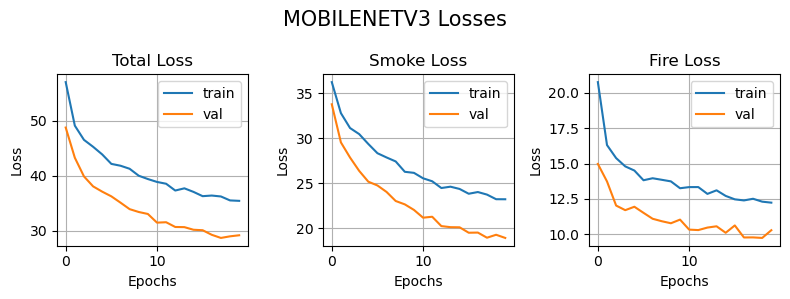

In [23]:
#plt.figure(figsize=(8,8))
fig, axs = plt.subplots(1,3, figsize=(8, 3))
fig.suptitle(MODEL + ' Losses', fontsize=15)

plt.subplot(1,3,1)
plt.plot(train_total_loss, label="train")
plt.plot(val_total_loss, label="val")
plt.title("Total Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(1,3,2)
plt.plot(train_smoke_loss, label="train")
plt.plot(val_smoke_loss, label="val")
plt.title("Smoke Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(1,3,3)
plt.plot(train_fire_loss, label="train")
plt.plot(val_fire_loss, label="val")
plt.title("Fire Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig(log_path + MODEL + "_losses.png")
plt.show()

# Fine Tuning

In [24]:
FIRST_EPOCH = EPOCHS
LEARNING_RATE = 1e-5
WEIGHT_DECAY = 1e-4
EPOCHS = 140 

In [25]:
for param in model_freeze.parameters():
    param.requires_grad = True

optimizer = optim.Adam(model_freeze.parameters(), 
                       lr=LEARNING_RATE, 
                       weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                 mode='min',
                                                 factor=0.8, 
                                                 patience=2, 
                                                 threshold=0.001, 
                                                 threshold_mode='abs',
                                                 min_lr=1e-7)
# MODEL PARAMETERS
n_trainable = sum(p.numel() for p in model_freeze.parameters() if p.requires_grad)
print(f'\nTrainable parameters = {n_trainable}')
logger.info(f'\nTrainable parameters = {n_trainable}')

n_params = parameters_to_vector(model_freeze.parameters()).numel()
print(f'Total parameters = {n_params}\n')
logger.info(f'Total parameters = {n_params}\n')


Trainable parameters = 945506
Total parameters = 945506



In [26]:
if __name__ == "__main__":
    print("Starting Fine Tuning\n")
    logger.info("Starting script\n")
    model_freeze = train_model(model=model_freeze, 
                               model_name=MODEL+'_FineTune',
                               optimizer=optimizer, 
                               scheduler=scheduler, 
                               first_epoch = FIRST_EPOCH,
                               epochs = EPOCHS)

Starting Fine Tuning


***Start Training: 19:05:48

Pretrained Weights

=== EPOCH 20/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.875      |22.207      |11.669      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.18it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.634      |17.469      |9.165       

SMOKE -> Precision: 0.875 - Recall: 0.896 - Accuracy: 0.888 - F1: 0.885
FIRE -> Precision: 0.881 - Recall: 0.904 - Accuracy: 0.943 - F1: 0.892

Saving model with new best validation loss: 26.634

=== EPOCH 21/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.75it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.744      |21.027      |10.717      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.19it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.383      |16.749      |8.634       

SMOKE -> Precision: 0.881 - Recall: 0.901 - Accuracy: 0.894 - F1: 0.891
FIRE -> Precision: 0.895 - Recall: 0.908 - Accuracy: 0.949 - F1: 0.902

Saving model with new best validation loss: 25.383

=== EPOCH 22/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.204      |19.988      |10.216      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.601      |16.240      |8.361       

SMOKE -> Precision: 0.885 - Recall: 0.904 - Accuracy: 0.897 - F1: 0.894
FIRE -> Precision: 0.898 - Recall: 0.909 - Accuracy: 0.950 - F1: 0.904

Saving model with new best validation loss: 24.601

=== EPOCH 23/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.298      |19.630      |9.668       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.79it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.863      |15.795      |8.068       

SMOKE -> Precision: 0.894 - Recall: 0.904 - Accuracy: 0.902 - F1: 0.899
FIRE -> Precision: 0.911 - Recall: 0.908 - Accuracy: 0.953 - F1: 0.909

Saving model with new best validation loss: 23.863

=== EPOCH 24/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.79it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.315      |18.745      |9.570       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.76it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.252      |15.337      |7.915       

SMOKE -> Precision: 0.899 - Recall: 0.906 - Accuracy: 0.906 - F1: 0.902
FIRE -> Precision: 0.909 - Recall: 0.915 - Accuracy: 0.954 - F1: 0.912

Saving model with new best validation loss: 23.252

=== EPOCH 25/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.75it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.403      |18.352      |9.051       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.04it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.815      |15.083      |7.732       

SMOKE -> Precision: 0.897 - Recall: 0.908 - Accuracy: 0.906 - F1: 0.902
FIRE -> Precision: 0.913 - Recall: 0.913 - Accuracy: 0.955 - F1: 0.913

Saving model with new best validation loss: 22.815

=== EPOCH 26/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.74it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.638      |17.478      |9.160       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.85it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.274      |14.698      |7.576       

SMOKE -> Precision: 0.899 - Recall: 0.910 - Accuracy: 0.907 - F1: 0.904
FIRE -> Precision: 0.911 - Recall: 0.918 - Accuracy: 0.956 - F1: 0.915

Saving model with new best validation loss: 22.274

=== EPOCH 27/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.070      |17.389      |8.681       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.87it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.812      |14.421      |7.392       

SMOKE -> Precision: 0.902 - Recall: 0.914 - Accuracy: 0.911 - F1: 0.908
FIRE -> Precision: 0.915 - Recall: 0.917 - Accuracy: 0.956 - F1: 0.916

Saving model with new best validation loss: 21.812

=== EPOCH 28/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.79it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.498      |16.875      |8.622       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.85it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.501      |14.214      |7.287       

SMOKE -> Precision: 0.901 - Recall: 0.917 - Accuracy: 0.912 - F1: 0.909
FIRE -> Precision: 0.918 - Recall: 0.920 - Accuracy: 0.958 - F1: 0.919

Saving model with new best validation loss: 21.501

=== EPOCH 29/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.50it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.878      |16.622      |8.256       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.059      |13.927      |7.132       

SMOKE -> Precision: 0.904 - Recall: 0.917 - Accuracy: 0.913 - F1: 0.910
FIRE -> Precision: 0.919 - Recall: 0.924 - Accuracy: 0.959 - F1: 0.921

Saving model with new best validation loss: 21.059

=== EPOCH 30/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.40it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.411      |16.340      |8.071       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.19it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.718      |13.677      |7.040       

SMOKE -> Precision: 0.903 - Recall: 0.923 - Accuracy: 0.915 - F1: 0.913
FIRE -> Precision: 0.917 - Recall: 0.927 - Accuracy: 0.959 - F1: 0.922

Saving model with new best validation loss: 20.718

=== EPOCH 31/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.55it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.886      |15.942      |7.944       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.27it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.397      |13.445      |6.952       

SMOKE -> Precision: 0.906 - Recall: 0.924 - Accuracy: 0.917 - F1: 0.915
FIRE -> Precision: 0.924 - Recall: 0.923 - Accuracy: 0.960 - F1: 0.923

Saving model with new best validation loss: 20.397

=== EPOCH 32/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.343      |15.653      |7.690       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.12it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.250      |13.357      |6.893       

SMOKE -> Precision: 0.904 - Recall: 0.925 - Accuracy: 0.917 - F1: 0.914
FIRE -> Precision: 0.918 - Recall: 0.928 - Accuracy: 0.960 - F1: 0.923

Saving model with new best validation loss: 20.250

=== EPOCH 33/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.62it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.209      |15.453      |7.756       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.21it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.663      |12.906      |6.758       

SMOKE -> Precision: 0.911 - Recall: 0.928 - Accuracy: 0.922 - F1: 0.920
FIRE -> Precision: 0.928 - Recall: 0.924 - Accuracy: 0.962 - F1: 0.926

Saving model with new best validation loss: 19.663

=== EPOCH 34/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.57it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.402      |14.852      |7.550       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.408      |12.721      |6.687       

SMOKE -> Precision: 0.913 - Recall: 0.932 - Accuracy: 0.925 - F1: 0.923
FIRE -> Precision: 0.924 - Recall: 0.928 - Accuracy: 0.962 - F1: 0.926

Saving model with new best validation loss: 19.408

=== EPOCH 35/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.74it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.386      |14.802      |7.584       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.54it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.045      |12.472      |6.574       

SMOKE -> Precision: 0.915 - Recall: 0.934 - Accuracy: 0.926 - F1: 0.924
FIRE -> Precision: 0.922 - Recall: 0.929 - Accuracy: 0.961 - F1: 0.925

Saving model with new best validation loss: 19.045

=== EPOCH 36/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.500      |14.333      |7.166       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.49it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.835      |12.319      |6.517       

SMOKE -> Precision: 0.921 - Recall: 0.931 - Accuracy: 0.928 - F1: 0.926
FIRE -> Precision: 0.925 - Recall: 0.927 - Accuracy: 0.962 - F1: 0.926

Saving model with new best validation loss: 18.835

=== EPOCH 37/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.372      |14.184      |7.188       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.36it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.576      |12.147      |6.429       

SMOKE -> Precision: 0.926 - Recall: 0.929 - Accuracy: 0.930 - F1: 0.927
FIRE -> Precision: 0.929 - Recall: 0.925 - Accuracy: 0.962 - F1: 0.927

Saving model with new best validation loss: 18.576

=== EPOCH 38/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.62it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.302      |14.159      |7.143       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.45it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.235      |11.870      |6.365       

SMOKE -> Precision: 0.923 - Recall: 0.936 - Accuracy: 0.932 - F1: 0.930
FIRE -> Precision: 0.931 - Recall: 0.929 - Accuracy: 0.964 - F1: 0.930

Saving model with new best validation loss: 18.235

=== EPOCH 39/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.077      |14.005      |7.072       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.059      |11.737      |6.322       

SMOKE -> Precision: 0.929 - Recall: 0.934 - Accuracy: 0.934 - F1: 0.931
FIRE -> Precision: 0.927 - Recall: 0.930 - Accuracy: 0.963 - F1: 0.928

Saving model with new best validation loss: 18.059

=== EPOCH 40/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.121      |13.456      |6.666       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.57it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.915      |11.623      |6.292       

SMOKE -> Precision: 0.928 - Recall: 0.935 - Accuracy: 0.934 - F1: 0.931
FIRE -> Precision: 0.927 - Recall: 0.928 - Accuracy: 0.962 - F1: 0.928

Saving model with new best validation loss: 17.915

=== EPOCH 41/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.302      |13.572      |6.730       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.79it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.697      |11.464      |6.233       

SMOKE -> Precision: 0.927 - Recall: 0.933 - Accuracy: 0.932 - F1: 0.930
FIRE -> Precision: 0.931 - Recall: 0.929 - Accuracy: 0.964 - F1: 0.930

Saving model with new best validation loss: 17.697

=== EPOCH 42/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.759      |13.085      |6.674       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.40it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.435      |11.248      |6.187       

SMOKE -> Precision: 0.927 - Recall: 0.942 - Accuracy: 0.937 - F1: 0.935
FIRE -> Precision: 0.931 - Recall: 0.931 - Accuracy: 0.964 - F1: 0.931

Saving model with new best validation loss: 17.435

=== EPOCH 43/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.395      |12.971      |6.424       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.43it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.293      |11.159      |6.134       

SMOKE -> Precision: 0.933 - Recall: 0.940 - Accuracy: 0.938 - F1: 0.936
FIRE -> Precision: 0.932 - Recall: 0.931 - Accuracy: 0.965 - F1: 0.931

Saving model with new best validation loss: 17.293

=== EPOCH 44/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.870      |12.663      |6.206       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.044      |10.966      |6.077       

SMOKE -> Precision: 0.938 - Recall: 0.939 - Accuracy: 0.941 - F1: 0.939
FIRE -> Precision: 0.932 - Recall: 0.932 - Accuracy: 0.965 - F1: 0.932

Saving model with new best validation loss: 17.044

=== EPOCH 45/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.74it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.173      |12.630      |6.543       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.80it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.018      |10.954      |6.065       

SMOKE -> Precision: 0.933 - Recall: 0.940 - Accuracy: 0.939 - F1: 0.937
FIRE -> Precision: 0.934 - Recall: 0.932 - Accuracy: 0.965 - F1: 0.933

Saving model with new best validation loss: 17.018

=== EPOCH 46/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.729      |12.317      |6.412       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.57it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.909      |10.893      |6.017       

SMOKE -> Precision: 0.932 - Recall: 0.947 - Accuracy: 0.941 - F1: 0.939
FIRE -> Precision: 0.935 - Recall: 0.930 - Accuracy: 0.965 - F1: 0.932

Saving model with new best validation loss: 16.909

=== EPOCH 47/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.296      |12.210      |6.086       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.93it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.687      |10.681      |6.006       

SMOKE -> Precision: 0.936 - Recall: 0.945 - Accuracy: 0.943 - F1: 0.941
FIRE -> Precision: 0.931 - Recall: 0.933 - Accuracy: 0.965 - F1: 0.932

Saving model with new best validation loss: 16.687

=== EPOCH 48/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.116      |11.968      |6.147       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.78it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.493      |10.550      |5.943       

SMOKE -> Precision: 0.936 - Recall: 0.945 - Accuracy: 0.942 - F1: 0.940
FIRE -> Precision: 0.932 - Recall: 0.933 - Accuracy: 0.965 - F1: 0.932

Saving model with new best validation loss: 16.493

=== EPOCH 49/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.650      |11.719      |5.931       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.476      |10.541      |5.935       

SMOKE -> Precision: 0.939 - Recall: 0.941 - Accuracy: 0.942 - F1: 0.940
FIRE -> Precision: 0.933 - Recall: 0.936 - Accuracy: 0.966 - F1: 0.934

Saving model with new best validation loss: 16.476

=== EPOCH 50/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.617      |11.536      |6.081       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.75it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.210      |10.342      |5.868       

SMOKE -> Precision: 0.938 - Recall: 0.949 - Accuracy: 0.945 - F1: 0.943
FIRE -> Precision: 0.938 - Recall: 0.936 - Accuracy: 0.967 - F1: 0.937

Saving model with new best validation loss: 16.210

=== EPOCH 51/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.396      |11.649      |5.747       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.129      |10.295      |5.833       

SMOKE -> Precision: 0.941 - Recall: 0.948 - Accuracy: 0.946 - F1: 0.944
FIRE -> Precision: 0.935 - Recall: 0.940 - Accuracy: 0.967 - F1: 0.937

Saving model with new best validation loss: 16.129

=== EPOCH 52/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.120      |11.397      |5.723       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.93it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.001      |10.172      |5.828       

SMOKE -> Precision: 0.940 - Recall: 0.949 - Accuracy: 0.947 - F1: 0.945
FIRE -> Precision: 0.938 - Recall: 0.934 - Accuracy: 0.967 - F1: 0.936

Saving model with new best validation loss: 16.001

=== EPOCH 53/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.73it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.921      |11.241      |5.680       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.87it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.110      |10.333      |5.777       

SMOKE -> Precision: 0.939 - Recall: 0.947 - Accuracy: 0.945 - F1: 0.943
FIRE -> Precision: 0.933 - Recall: 0.940 - Accuracy: 0.967 - F1: 0.936

=== EPOCH 54/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.414      |10.873      |5.542       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.54it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
15.858      |10.103      |5.754       

SMOKE -> Precision: 0.940 - Recall: 0.951 - Accuracy: 0.947 - F1: 0.945
FIRE -> Precision: 0.935 - Recall: 0.940 - Accuracy: 0.967 - F1: 0.937

Saving model with new best validation loss: 15.858

=== EPOCH 55/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.339      |11.019      |5.320       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
15.754      |10.003      |5.751       

SMOKE -> Precision: 0.943 - Recall: 0.949 - Accuracy: 0.948 - F1: 0.946
FIRE -> Precision: 0.937 - Recall: 0.939 - Accuracy: 0.968 - F1: 0.938

Saving model with new best validation loss: 15.754

=== EPOCH 56/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.75it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.120      |10.596      |5.525       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
15.634      |9.913       |5.721       

SMOKE -> Precision: 0.939 - Recall: 0.954 - Accuracy: 0.948 - F1: 0.947
FIRE -> Precision: 0.939 - Recall: 0.936 - Accuracy: 0.968 - F1: 0.937

Saving model with new best validation loss: 15.634

=== EPOCH 57/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
15.854      |10.306      |5.548       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.73it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
15.506      |9.826       |5.680       

SMOKE -> Precision: 0.940 - Recall: 0.950 - Accuracy: 0.947 - F1: 0.945
FIRE -> Precision: 0.941 - Recall: 0.936 - Accuracy: 0.968 - F1: 0.939

Saving model with new best validation loss: 15.506

=== EPOCH 58/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.74it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
15.479      |10.281      |5.198       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.29it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
15.435      |9.772       |5.663       

SMOKE -> Precision: 0.939 - Recall: 0.954 - Accuracy: 0.948 - F1: 0.947
FIRE -> Precision: 0.940 - Recall: 0.941 - Accuracy: 0.969 - F1: 0.941

Saving model with new best validation loss: 15.435

=== EPOCH 59/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
15.777      |10.463      |5.314       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.74it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
15.523      |9.857       |5.666       

SMOKE -> Precision: 0.941 - Recall: 0.948 - Accuracy: 0.946 - F1: 0.944
FIRE -> Precision: 0.940 - Recall: 0.940 - Accuracy: 0.969 - F1: 0.940

=== EPOCH 60/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
15.344      |10.174      |5.170       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.76it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
15.342      |9.715       |5.627       

SMOKE -> Precision: 0.945 - Recall: 0.952 - Accuracy: 0.950 - F1: 0.948
FIRE -> Precision: 0.939 - Recall: 0.937 - Accuracy: 0.968 - F1: 0.938

Saving model with new best validation loss: 15.342

=== EPOCH 61/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.61it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
14.987      |9.911       |5.076       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.56it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
15.251      |9.613       |5.638       

SMOKE -> Precision: 0.943 - Recall: 0.953 - Accuracy: 0.950 - F1: 0.948
FIRE -> Precision: 0.941 - Recall: 0.937 - Accuracy: 0.969 - F1: 0.939

Saving model with new best validation loss: 15.251

=== EPOCH 62/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
15.215      |10.044      |5.171       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.73it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
15.085      |9.464       |5.622       

SMOKE -> Precision: 0.946 - Recall: 0.955 - Accuracy: 0.952 - F1: 0.951
FIRE -> Precision: 0.942 - Recall: 0.939 - Accuracy: 0.969 - F1: 0.940

Saving model with new best validation loss: 15.085

=== EPOCH 63/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.80it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
14.581      |9.497       |5.083       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.57it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
15.163      |9.559       |5.604       

SMOKE -> Precision: 0.943 - Recall: 0.951 - Accuracy: 0.949 - F1: 0.947
FIRE -> Precision: 0.944 - Recall: 0.939 - Accuracy: 0.970 - F1: 0.941

=== EPOCH 64/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
14.569      |9.695       |4.874       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
14.923      |9.367       |5.556       

SMOKE -> Precision: 0.945 - Recall: 0.955 - Accuracy: 0.952 - F1: 0.950
FIRE -> Precision: 0.942 - Recall: 0.939 - Accuracy: 0.969 - F1: 0.940

Saving model with new best validation loss: 14.923

=== EPOCH 65/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.73it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
14.494      |9.548       |4.946       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.76it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
14.957      |9.375       |5.582       

SMOKE -> Precision: 0.942 - Recall: 0.954 - Accuracy: 0.950 - F1: 0.948
FIRE -> Precision: 0.940 - Recall: 0.940 - Accuracy: 0.969 - F1: 0.940

=== EPOCH 66/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
14.213      |9.314       |4.900       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
14.838      |9.265       |5.573       

SMOKE -> Precision: 0.944 - Recall: 0.952 - Accuracy: 0.950 - F1: 0.948
FIRE -> Precision: 0.941 - Recall: 0.938 - Accuracy: 0.969 - F1: 0.940

Saving model with new best validation loss: 14.838

=== EPOCH 67/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.74it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
14.213      |9.350       |4.863       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
14.853      |9.335       |5.517       

SMOKE -> Precision: 0.946 - Recall: 0.951 - Accuracy: 0.950 - F1: 0.948
FIRE -> Precision: 0.943 - Recall: 0.938 - Accuracy: 0.969 - F1: 0.940

=== EPOCH 68/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.79it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
14.256      |9.381       |4.875       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.55it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
14.716      |9.186       |5.530       

SMOKE -> Precision: 0.946 - Recall: 0.956 - Accuracy: 0.952 - F1: 0.951
FIRE -> Precision: 0.941 - Recall: 0.941 - Accuracy: 0.969 - F1: 0.941

Saving model with new best validation loss: 14.716

=== EPOCH 69/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
14.047      |9.218       |4.829       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
14.687      |9.215       |5.472       

SMOKE -> Precision: 0.945 - Recall: 0.956 - Accuracy: 0.952 - F1: 0.951
FIRE -> Precision: 0.942 - Recall: 0.939 - Accuracy: 0.969 - F1: 0.940

Saving model with new best validation loss: 14.687

=== EPOCH 70/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.73it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
13.839      |9.156       |4.683       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.34it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
14.701      |9.185       |5.516       

SMOKE -> Precision: 0.942 - Recall: 0.954 - Accuracy: 0.949 - F1: 0.948
FIRE -> Precision: 0.944 - Recall: 0.940 - Accuracy: 0.970 - F1: 0.942

=== EPOCH 71/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.54it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
13.439      |9.031       |4.409       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
14.628      |9.162       |5.466       

SMOKE -> Precision: 0.944 - Recall: 0.953 - Accuracy: 0.950 - F1: 0.948
FIRE -> Precision: 0.942 - Recall: 0.940 - Accuracy: 0.969 - F1: 0.941

Saving model with new best validation loss: 14.628

=== EPOCH 72/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
13.267      |8.773       |4.494       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.57it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
14.515      |9.048       |5.466       

SMOKE -> Precision: 0.946 - Recall: 0.958 - Accuracy: 0.954 - F1: 0.952
FIRE -> Precision: 0.942 - Recall: 0.941 - Accuracy: 0.970 - F1: 0.942

Saving model with new best validation loss: 14.515

=== EPOCH 73/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.74it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
13.484      |8.896       |4.588       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.51it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
14.403      |8.939       |5.464       

SMOKE -> Precision: 0.946 - Recall: 0.959 - Accuracy: 0.954 - F1: 0.952
FIRE -> Precision: 0.946 - Recall: 0.940 - Accuracy: 0.971 - F1: 0.943

Saving model with new best validation loss: 14.403

=== EPOCH 74/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
13.036      |8.555       |4.482       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.41it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
14.425      |8.953       |5.473       

SMOKE -> Precision: 0.946 - Recall: 0.957 - Accuracy: 0.953 - F1: 0.952
FIRE -> Precision: 0.945 - Recall: 0.939 - Accuracy: 0.970 - F1: 0.942

=== EPOCH 75/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
12.965      |8.615       |4.350       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
14.525      |8.992       |5.532       

SMOKE -> Precision: 0.944 - Recall: 0.957 - Accuracy: 0.952 - F1: 0.951
FIRE -> Precision: 0.944 - Recall: 0.938 - Accuracy: 0.969 - F1: 0.941

=== EPOCH 76/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
12.667      |8.373       |4.294       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
14.387      |8.897       |5.490       

SMOKE -> Precision: 0.946 - Recall: 0.960 - Accuracy: 0.955 - F1: 0.953
FIRE -> Precision: 0.945 - Recall: 0.937 - Accuracy: 0.970 - F1: 0.941

Saving model with new best validation loss: 14.387

=== EPOCH 77/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
12.811      |8.352       |4.459       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.49it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
14.414      |8.932       |5.482       

SMOKE -> Precision: 0.948 - Recall: 0.953 - Accuracy: 0.953 - F1: 0.951
FIRE -> Precision: 0.944 - Recall: 0.941 - Accuracy: 0.970 - F1: 0.943

=== EPOCH 78/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
12.743      |8.356       |4.387       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.55it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
14.411      |8.938       |5.473       

SMOKE -> Precision: 0.946 - Recall: 0.955 - Accuracy: 0.952 - F1: 0.951
FIRE -> Precision: 0.944 - Recall: 0.942 - Accuracy: 0.971 - F1: 0.943

=== EPOCH 79/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.87it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
12.457      |8.215       |4.242       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.49it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
14.220      |8.745       |5.475       

SMOKE -> Precision: 0.949 - Recall: 0.955 - Accuracy: 0.954 - F1: 0.952
FIRE -> Precision: 0.945 - Recall: 0.942 - Accuracy: 0.971 - F1: 0.944

Saving model with new best validation loss: 14.220

=== EPOCH 80/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
12.401      |8.098       |4.303       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
14.095      |8.650       |5.444       

SMOKE -> Precision: 0.947 - Recall: 0.961 - Accuracy: 0.955 - F1: 0.954
FIRE -> Precision: 0.946 - Recall: 0.941 - Accuracy: 0.971 - F1: 0.943

Saving model with new best validation loss: 14.095

=== EPOCH 81/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
12.346      |8.173       |4.173       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.18it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
14.136      |8.705       |5.431       

SMOKE -> Precision: 0.948 - Recall: 0.958 - Accuracy: 0.955 - F1: 0.953
FIRE -> Precision: 0.942 - Recall: 0.940 - Accuracy: 0.969 - F1: 0.941

=== EPOCH 82/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.74it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
12.389      |8.067       |4.322       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.51it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
14.179      |8.738       |5.441       

SMOKE -> Precision: 0.950 - Recall: 0.954 - Accuracy: 0.954 - F1: 0.952
FIRE -> Precision: 0.946 - Recall: 0.940 - Accuracy: 0.970 - F1: 0.943

=== EPOCH 83/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
11.815      |7.708       |4.108       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
14.105      |8.699       |5.406       

SMOKE -> Precision: 0.948 - Recall: 0.953 - Accuracy: 0.952 - F1: 0.951
FIRE -> Precision: 0.948 - Recall: 0.941 - Accuracy: 0.972 - F1: 0.945

=== EPOCH 84/159 ===
Learning Rate = 8.000000000000001e-06



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
11.697      |7.611       |4.087       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.48it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
14.092      |8.695       |5.397       

SMOKE -> Precision: 0.949 - Recall: 0.954 - Accuracy: 0.953 - F1: 0.951
FIRE -> Precision: 0.948 - Recall: 0.942 - Accuracy: 0.972 - F1: 0.945

Saving model with new best validation loss: 14.092

=== EPOCH 85/159 ===
Learning Rate = 8.000000000000001e-06



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
11.608      |7.595       |4.014       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.39it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
13.997      |8.630       |5.368       

SMOKE -> Precision: 0.948 - Recall: 0.955 - Accuracy: 0.953 - F1: 0.951
FIRE -> Precision: 0.948 - Recall: 0.941 - Accuracy: 0.972 - F1: 0.945

Saving model with new best validation loss: 13.997

=== EPOCH 86/159 ===
Learning Rate = 8.000000000000001e-06



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
11.277      |7.344       |3.933       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
14.059      |8.650       |5.409       

SMOKE -> Precision: 0.948 - Recall: 0.954 - Accuracy: 0.953 - F1: 0.951
FIRE -> Precision: 0.943 - Recall: 0.945 - Accuracy: 0.971 - F1: 0.944

=== EPOCH 87/159 ===
Learning Rate = 8.000000000000001e-06



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
11.517      |7.480       |4.037       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
13.908      |8.507       |5.401       

SMOKE -> Precision: 0.951 - Recall: 0.959 - Accuracy: 0.956 - F1: 0.955
FIRE -> Precision: 0.947 - Recall: 0.942 - Accuracy: 0.971 - F1: 0.944

Saving model with new best validation loss: 13.908

=== EPOCH 88/159 ===
Learning Rate = 8.000000000000001e-06



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
11.557      |7.538       |4.019       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.39it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
13.902      |8.532       |5.370       

SMOKE -> Precision: 0.950 - Recall: 0.959 - Accuracy: 0.956 - F1: 0.954
FIRE -> Precision: 0.947 - Recall: 0.942 - Accuracy: 0.972 - F1: 0.945

Saving model with new best validation loss: 13.902

=== EPOCH 89/159 ===
Learning Rate = 8.000000000000001e-06



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
11.289      |7.529       |3.760       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.56it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
13.913      |8.525       |5.388       

SMOKE -> Precision: 0.950 - Recall: 0.956 - Accuracy: 0.955 - F1: 0.953
FIRE -> Precision: 0.947 - Recall: 0.941 - Accuracy: 0.971 - F1: 0.944

=== EPOCH 90/159 ===
Learning Rate = 8.000000000000001e-06



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
11.283      |7.488       |3.795       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.20it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
13.998      |8.593       |5.405       

SMOKE -> Precision: 0.950 - Recall: 0.955 - Accuracy: 0.954 - F1: 0.953
FIRE -> Precision: 0.946 - Recall: 0.944 - Accuracy: 0.972 - F1: 0.945

=== EPOCH 91/159 ===
Learning Rate = 8.000000000000001e-06



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
11.381      |7.414       |3.967       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
13.898      |8.494       |5.404       

SMOKE -> Precision: 0.951 - Recall: 0.957 - Accuracy: 0.956 - F1: 0.954
FIRE -> Precision: 0.949 - Recall: 0.942 - Accuracy: 0.972 - F1: 0.946

Saving model with new best validation loss: 13.898

=== EPOCH 92/159 ===
Learning Rate = 8.000000000000001e-06



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
11.007      |7.259       |3.748       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.40it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
13.947      |8.562       |5.385       

SMOKE -> Precision: 0.950 - Recall: 0.956 - Accuracy: 0.955 - F1: 0.953
FIRE -> Precision: 0.948 - Recall: 0.944 - Accuracy: 0.972 - F1: 0.946

=== EPOCH 93/159 ===
Learning Rate = 8.000000000000001e-06



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.61it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
11.002      |7.215       |3.787       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.27it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
13.770      |8.380       |5.390       

SMOKE -> Precision: 0.951 - Recall: 0.960 - Accuracy: 0.957 - F1: 0.955
FIRE -> Precision: 0.949 - Recall: 0.946 - Accuracy: 0.973 - F1: 0.947

Saving model with new best validation loss: 13.770

=== EPOCH 94/159 ===
Learning Rate = 8.000000000000001e-06



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
10.513      |6.934       |3.579       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.24it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
13.856      |8.471       |5.385       

SMOKE -> Precision: 0.952 - Recall: 0.956 - Accuracy: 0.955 - F1: 0.954
FIRE -> Precision: 0.951 - Recall: 0.944 - Accuracy: 0.973 - F1: 0.948

=== EPOCH 95/159 ===
Learning Rate = 8.000000000000001e-06



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.55it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
10.575      |6.832       |3.743       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.19it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
13.846      |8.443       |5.402       

SMOKE -> Precision: 0.952 - Recall: 0.957 - Accuracy: 0.956 - F1: 0.954
FIRE -> Precision: 0.949 - Recall: 0.944 - Accuracy: 0.972 - F1: 0.947

=== EPOCH 96/159 ===
Learning Rate = 8.000000000000001e-06



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
10.710      |6.995       |3.716       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.56it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
13.802      |8.411       |5.391       

SMOKE -> Precision: 0.949 - Recall: 0.957 - Accuracy: 0.955 - F1: 0.953
FIRE -> Precision: 0.950 - Recall: 0.942 - Accuracy: 0.972 - F1: 0.946

=== EPOCH 97/159 ===
Learning Rate = 6.400000000000001e-06



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
10.520      |6.914       |3.606       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.43it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
13.875      |8.483       |5.392       

SMOKE -> Precision: 0.952 - Recall: 0.957 - Accuracy: 0.956 - F1: 0.955
FIRE -> Precision: 0.950 - Recall: 0.941 - Accuracy: 0.972 - F1: 0.945

=== EPOCH 98/159 ===
Learning Rate = 6.400000000000001e-06



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
10.475      |6.907       |3.568       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.47it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
13.837      |8.481       |5.356       

SMOKE -> Precision: 0.951 - Recall: 0.956 - Accuracy: 0.955 - F1: 0.954
FIRE -> Precision: 0.948 - Recall: 0.945 - Accuracy: 0.972 - F1: 0.947

=== EPOCH 99/159 ===
Learning Rate = 6.400000000000001e-06



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
10.380      |6.867       |3.513       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.51it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
13.832      |8.461       |5.371       

SMOKE -> Precision: 0.951 - Recall: 0.955 - Accuracy: 0.955 - F1: 0.953
FIRE -> Precision: 0.949 - Recall: 0.945 - Accuracy: 0.973 - F1: 0.947

=== EPOCH 100/159 ===
Learning Rate = 5.120000000000002e-06



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
10.481      |6.784       |3.697       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.24it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
13.833      |8.471       |5.362       

SMOKE -> Precision: 0.951 - Recall: 0.959 - Accuracy: 0.956 - F1: 0.955
FIRE -> Precision: 0.950 - Recall: 0.943 - Accuracy: 0.972 - F1: 0.947

=== EPOCH 101/159 ===
Learning Rate = 5.120000000000002e-06



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.73it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
10.320      |6.754       |3.567       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.07it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
13.777      |8.420       |5.356       

SMOKE -> Precision: 0.953 - Recall: 0.957 - Accuracy: 0.956 - F1: 0.955
FIRE -> Precision: 0.950 - Recall: 0.942 - Accuracy: 0.972 - F1: 0.946

=== EPOCH 102/159 ===
Learning Rate = 5.120000000000002e-06



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.75it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
10.301      |6.699       |3.603       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.29it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
13.763      |8.408       |5.356       

SMOKE -> Precision: 0.950 - Recall: 0.958 - Accuracy: 0.955 - F1: 0.954
FIRE -> Precision: 0.949 - Recall: 0.944 - Accuracy: 0.972 - F1: 0.947

Saving model with new best validation loss: 13.763

=== EPOCH 103/159 ===
Learning Rate = 5.120000000000002e-06



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
10.154      |6.715       |3.439       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.21it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
13.718      |8.348       |5.369       

SMOKE -> Precision: 0.950 - Recall: 0.960 - Accuracy: 0.957 - F1: 0.955
FIRE -> Precision: 0.949 - Recall: 0.944 - Accuracy: 0.972 - F1: 0.947

Saving model with new best validation loss: 13.718

=== EPOCH 104/159 ===
Learning Rate = 5.120000000000002e-06



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.59it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
10.194      |6.565       |3.629       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
13.856      |8.451       |5.405       

SMOKE -> Precision: 0.951 - Recall: 0.956 - Accuracy: 0.955 - F1: 0.953
FIRE -> Precision: 0.949 - Recall: 0.946 - Accuracy: 0.973 - F1: 0.947

=== EPOCH 105/159 ===
Learning Rate = 5.120000000000002e-06



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.55it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
10.349      |6.729       |3.620       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
13.714      |8.330       |5.384       

SMOKE -> Precision: 0.951 - Recall: 0.958 - Accuracy: 0.956 - F1: 0.955
FIRE -> Precision: 0.949 - Recall: 0.943 - Accuracy: 0.972 - F1: 0.946

Saving model with new best validation loss: 13.714

=== EPOCH 106/159 ===
Learning Rate = 5.120000000000002e-06



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.61it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
10.284      |6.605       |3.679       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
13.774      |8.389       |5.384       

SMOKE -> Precision: 0.950 - Recall: 0.959 - Accuracy: 0.956 - F1: 0.954
FIRE -> Precision: 0.950 - Recall: 0.943 - Accuracy: 0.972 - F1: 0.947

=== EPOCH 107/159 ===
Learning Rate = 5.120000000000002e-06



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.75it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
9.951       |6.498       |3.452       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.12it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
13.684      |8.292       |5.391       

SMOKE -> Precision: 0.951 - Recall: 0.959 - Accuracy: 0.956 - F1: 0.955
FIRE -> Precision: 0.949 - Recall: 0.945 - Accuracy: 0.973 - F1: 0.947

Saving model with new best validation loss: 13.684

=== EPOCH 108/159 ===
Learning Rate = 5.120000000000002e-06



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
10.059      |6.530       |3.530       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.25it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
13.660      |8.277       |5.383       

SMOKE -> Precision: 0.951 - Recall: 0.959 - Accuracy: 0.957 - F1: 0.955
FIRE -> Precision: 0.948 - Recall: 0.943 - Accuracy: 0.972 - F1: 0.946

Saving model with new best validation loss: 13.660

=== EPOCH 109/159 ===
Learning Rate = 5.120000000000002e-06



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
10.268      |6.728       |3.539       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.37it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
13.792      |8.399       |5.393       

SMOKE -> Precision: 0.950 - Recall: 0.958 - Accuracy: 0.955 - F1: 0.954
FIRE -> Precision: 0.949 - Recall: 0.944 - Accuracy: 0.972 - F1: 0.947

=== EPOCH 110/159 ===
Learning Rate = 5.120000000000002e-06



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
9.922       |6.526       |3.396       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
13.792      |8.389       |5.403       

SMOKE -> Precision: 0.950 - Recall: 0.961 - Accuracy: 0.957 - F1: 0.955
FIRE -> Precision: 0.949 - Recall: 0.943 - Accuracy: 0.972 - F1: 0.946

=== EPOCH 111/159 ===
Learning Rate = 5.120000000000002e-06



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
9.873       |6.519       |3.354       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.18it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
13.759      |8.358       |5.400       

SMOKE -> Precision: 0.951 - Recall: 0.959 - Accuracy: 0.957 - F1: 0.955
FIRE -> Precision: 0.949 - Recall: 0.943 - Accuracy: 0.972 - F1: 0.946

=== EPOCH 112/159 ===
Learning Rate = 4.096000000000002e-06



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
9.729       |6.393       |3.336       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.25it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
13.750      |8.363       |5.388       

SMOKE -> Precision: 0.949 - Recall: 0.959 - Accuracy: 0.955 - F1: 0.954
FIRE -> Precision: 0.948 - Recall: 0.945 - Accuracy: 0.972 - F1: 0.947

=== EPOCH 113/159 ===
Learning Rate = 4.096000000000002e-06



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.59it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
9.440       |6.164       |3.276       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
13.814      |8.385       |5.429       

SMOKE -> Precision: 0.950 - Recall: 0.958 - Accuracy: 0.955 - F1: 0.954
FIRE -> Precision: 0.950 - Recall: 0.945 - Accuracy: 0.973 - F1: 0.948

=== EPOCH 114/159 ===
Learning Rate = 4.096000000000002e-06



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.62it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
9.464       |6.205       |3.259       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
13.818      |8.385       |5.432       

SMOKE -> Precision: 0.950 - Recall: 0.955 - Accuracy: 0.955 - F1: 0.953
FIRE -> Precision: 0.948 - Recall: 0.944 - Accuracy: 0.972 - F1: 0.946

=== EPOCH 115/159 ===
Learning Rate = 3.276800000000002e-06



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
9.565       |6.189       |3.376       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.10it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
13.788      |8.360       |5.428       

SMOKE -> Precision: 0.949 - Recall: 0.957 - Accuracy: 0.955 - F1: 0.953
FIRE -> Precision: 0.949 - Recall: 0.944 - Accuracy: 0.972 - F1: 0.947

=== EPOCH 116/159 ===
Learning Rate = 3.276800000000002e-06



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
9.794       |6.430       |3.364       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
13.738      |8.313       |5.424       

SMOKE -> Precision: 0.951 - Recall: 0.958 - Accuracy: 0.956 - F1: 0.954
FIRE -> Precision: 0.949 - Recall: 0.944 - Accuracy: 0.972 - F1: 0.947

=== EPOCH 117/159 ===
Learning Rate = 3.276800000000002e-06



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.73it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
9.730       |6.437       |3.292       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
13.758      |8.331       |5.428       

SMOKE -> Precision: 0.952 - Recall: 0.957 - Accuracy: 0.956 - F1: 0.955
FIRE -> Precision: 0.948 - Recall: 0.945 - Accuracy: 0.972 - F1: 0.947

=== EPOCH 118/159 ===
Learning Rate = 2.6214400000000015e-06



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.62it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
9.403       |6.272       |3.132       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.14it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
13.759      |8.335       |5.424       

SMOKE -> Precision: 0.951 - Recall: 0.958 - Accuracy: 0.956 - F1: 0.955
FIRE -> Precision: 0.949 - Recall: 0.945 - Accuracy: 0.973 - F1: 0.947

=== EPOCH 119/159 ===
Learning Rate = 2.6214400000000015e-06



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
9.283       |6.068       |3.215       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.85it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
13.825      |8.395       |5.430       

SMOKE -> Precision: 0.951 - Recall: 0.958 - Accuracy: 0.956 - F1: 0.954
FIRE -> Precision: 0.949 - Recall: 0.945 - Accuracy: 0.973 - F1: 0.947

=== EPOCH 120/159 ===
Learning Rate = 2.6214400000000015e-06



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
9.346       |6.148       |3.197       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
13.804      |8.372       |5.432       

SMOKE -> Precision: 0.950 - Recall: 0.958 - Accuracy: 0.956 - F1: 0.954
FIRE -> Precision: 0.949 - Recall: 0.945 - Accuracy: 0.973 - F1: 0.947

=== EPOCH 121/159 ===
Learning Rate = 2.0971520000000012e-06



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
9.431       |6.200       |3.231       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.08it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
13.780      |8.346       |5.434       

SMOKE -> Precision: 0.951 - Recall: 0.959 - Accuracy: 0.956 - F1: 0.955
FIRE -> Precision: 0.950 - Recall: 0.944 - Accuracy: 0.973 - F1: 0.947

=== EPOCH 122/159 ===
Learning Rate = 2.0971520000000012e-06



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
9.309       |6.080       |3.229       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
13.780      |8.336       |5.445       

SMOKE -> Precision: 0.951 - Recall: 0.958 - Accuracy: 0.956 - F1: 0.955
FIRE -> Precision: 0.949 - Recall: 0.945 - Accuracy: 0.973 - F1: 0.947

=== EPOCH 123/159 ===
Learning Rate = 2.0971520000000012e-06



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
9.347       |6.138       |3.209       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.91it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
13.732      |8.300       |5.432       

SMOKE -> Precision: 0.952 - Recall: 0.958 - Accuracy: 0.957 - F1: 0.955
FIRE -> Precision: 0.949 - Recall: 0.946 - Accuracy: 0.973 - F1: 0.948

=== EPOCH 124/159 ===
Learning Rate = 1.6777216000000011e-06



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
9.254       |6.024       |3.230       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.14it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
13.742      |8.301       |5.441       

SMOKE -> Precision: 0.952 - Recall: 0.958 - Accuracy: 0.957 - F1: 0.955
FIRE -> Precision: 0.949 - Recall: 0.947 - Accuracy: 0.973 - F1: 0.948

=== EPOCH 125/159 ===
Learning Rate = 1.6777216000000011e-06



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
9.440       |6.295       |3.146       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.12it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
13.747      |8.295       |5.452       

SMOKE -> Precision: 0.952 - Recall: 0.958 - Accuracy: 0.957 - F1: 0.955
FIRE -> Precision: 0.949 - Recall: 0.946 - Accuracy: 0.973 - F1: 0.947

=== EPOCH 126/159 ===
Learning Rate = 1.6777216000000011e-06



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.62it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
9.438       |6.174       |3.264       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.11it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
13.736      |8.304       |5.432       

SMOKE -> Precision: 0.951 - Recall: 0.958 - Accuracy: 0.956 - F1: 0.955
FIRE -> Precision: 0.951 - Recall: 0.945 - Accuracy: 0.973 - F1: 0.948

=== EPOCH 127/159 ===
Learning Rate = 1.342177280000001e-06



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
9.217       |5.990       |3.226       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
13.721      |8.273       |5.448       

SMOKE -> Precision: 0.952 - Recall: 0.959 - Accuracy: 0.957 - F1: 0.956
FIRE -> Precision: 0.950 - Recall: 0.945 - Accuracy: 0.973 - F1: 0.948

=== EPOCH 128/159 ===
Learning Rate = 1.342177280000001e-06



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
9.472       |6.115       |3.357       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.12it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
13.732      |8.294       |5.438       

SMOKE -> Precision: 0.951 - Recall: 0.958 - Accuracy: 0.956 - F1: 0.954
FIRE -> Precision: 0.950 - Recall: 0.945 - Accuracy: 0.973 - F1: 0.948

=== EPOCH 129/159 ===
Learning Rate = 1.342177280000001e-06



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
8.971       |5.982       |2.989       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.84it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
13.752      |8.308       |5.445       

SMOKE -> Precision: 0.952 - Recall: 0.957 - Accuracy: 0.956 - F1: 0.955
FIRE -> Precision: 0.951 - Recall: 0.945 - Accuracy: 0.973 - F1: 0.948

=== EPOCH 130/159 ===
Learning Rate = 1.073741824000001e-06



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.59it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
9.435       |6.126       |3.309       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
13.722      |8.292       |5.430       

SMOKE -> Precision: 0.952 - Recall: 0.958 - Accuracy: 0.957 - F1: 0.955
FIRE -> Precision: 0.950 - Recall: 0.944 - Accuracy: 0.973 - F1: 0.947

=== EPOCH 131/159 ===
Learning Rate = 1.073741824000001e-06



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
9.102       |5.999       |3.103       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
13.727      |8.286       |5.442       

SMOKE -> Precision: 0.952 - Recall: 0.959 - Accuracy: 0.957 - F1: 0.956
FIRE -> Precision: 0.950 - Recall: 0.945 - Accuracy: 0.973 - F1: 0.948

=== EPOCH 132/159 ===
Learning Rate = 1.073741824000001e-06



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
9.245       |6.097       |3.148       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.04it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
13.731      |8.282       |5.449       

SMOKE -> Precision: 0.952 - Recall: 0.958 - Accuracy: 0.957 - F1: 0.955
FIRE -> Precision: 0.950 - Recall: 0.945 - Accuracy: 0.973 - F1: 0.948

=== EPOCH 133/159 ===
Learning Rate = 8.589934592000008e-07



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.62it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
9.460       |6.226       |3.234       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.07it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
13.744      |8.295       |5.450       

SMOKE -> Precision: 0.951 - Recall: 0.959 - Accuracy: 0.957 - F1: 0.955
FIRE -> Precision: 0.951 - Recall: 0.946 - Accuracy: 0.973 - F1: 0.949

=== EPOCH 134/159 ===
Learning Rate = 8.589934592000008e-07



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.73it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
9.379       |6.118       |3.261       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.89it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
13.753      |8.296       |5.457       

SMOKE -> Precision: 0.952 - Recall: 0.958 - Accuracy: 0.957 - F1: 0.955
FIRE -> Precision: 0.951 - Recall: 0.945 - Accuracy: 0.973 - F1: 0.948

=== EPOCH 135/159 ===
Learning Rate = 8.589934592000008e-07



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
9.187       |6.072       |3.116       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.07it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
13.726      |8.279       |5.447       

SMOKE -> Precision: 0.953 - Recall: 0.958 - Accuracy: 0.957 - F1: 0.955
FIRE -> Precision: 0.952 - Recall: 0.944 - Accuracy: 0.973 - F1: 0.948

=== EPOCH 136/159 ===
Learning Rate = 6.871947673600007e-07



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.73it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
9.284       |6.137       |3.148       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.84it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
13.713      |8.260       |5.452       

SMOKE -> Precision: 0.953 - Recall: 0.959 - Accuracy: 0.957 - F1: 0.956
FIRE -> Precision: 0.951 - Recall: 0.945 - Accuracy: 0.973 - F1: 0.948

=== EPOCH 137/159 ===
Learning Rate = 6.871947673600007e-07



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
9.084       |5.874       |3.210       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.07it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
13.722      |8.279       |5.443       

SMOKE -> Precision: 0.953 - Recall: 0.959 - Accuracy: 0.957 - F1: 0.956
FIRE -> Precision: 0.951 - Recall: 0.945 - Accuracy: 0.973 - F1: 0.948

=== EPOCH 138/159 ===
Learning Rate = 6.871947673600007e-07



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
9.135       |5.874       |3.261       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.85it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
13.714      |8.275       |5.440       

SMOKE -> Precision: 0.953 - Recall: 0.959 - Accuracy: 0.957 - F1: 0.956
FIRE -> Precision: 0.951 - Recall: 0.945 - Accuracy: 0.973 - F1: 0.948

=== EPOCH 139/159 ===
Learning Rate = 5.497558138880006e-07



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
9.090       |5.981       |3.108       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.86it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
13.718      |8.271       |5.447       

SMOKE -> Precision: 0.953 - Recall: 0.959 - Accuracy: 0.958 - F1: 0.956
FIRE -> Precision: 0.950 - Recall: 0.945 - Accuracy: 0.973 - F1: 0.948

=== EPOCH 140/159 ===
Learning Rate = 5.497558138880006e-07



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
9.386       |6.110       |3.276       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.94it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
13.760      |8.310       |5.450       

SMOKE -> Precision: 0.953 - Recall: 0.959 - Accuracy: 0.957 - F1: 0.956
FIRE -> Precision: 0.951 - Recall: 0.945 - Accuracy: 0.973 - F1: 0.948

=== EPOCH 141/159 ===
Learning Rate = 5.497558138880006e-07



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
9.236       |6.043       |3.192       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.80it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
13.726      |8.285       |5.441       

SMOKE -> Precision: 0.952 - Recall: 0.958 - Accuracy: 0.957 - F1: 0.955
FIRE -> Precision: 0.953 - Recall: 0.944 - Accuracy: 0.973 - F1: 0.948

=== EPOCH 142/159 ===
Learning Rate = 4.3980465111040047e-07



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
9.056       |6.031       |3.026       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
13.724      |8.286       |5.438       

SMOKE -> Precision: 0.952 - Recall: 0.959 - Accuracy: 0.957 - F1: 0.956
FIRE -> Precision: 0.951 - Recall: 0.945 - Accuracy: 0.973 - F1: 0.948

=== EPOCH 143/159 ===
Learning Rate = 4.3980465111040047e-07



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
9.372       |6.100       |3.272       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.87it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
13.715      |8.269       |5.446       

SMOKE -> Precision: 0.952 - Recall: 0.960 - Accuracy: 0.958 - F1: 0.956
FIRE -> Precision: 0.949 - Recall: 0.946 - Accuracy: 0.973 - F1: 0.948

=== EPOCH 144/159 ===
Learning Rate = 4.3980465111040047e-07



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
8.916       |5.857       |3.059       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
13.729      |8.283       |5.447       

SMOKE -> Precision: 0.953 - Recall: 0.959 - Accuracy: 0.958 - F1: 0.956
FIRE -> Precision: 0.952 - Recall: 0.944 - Accuracy: 0.973 - F1: 0.948

=== EPOCH 145/159 ===
Learning Rate = 3.518437208883204e-07



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
9.121       |6.039       |3.082       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.73it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
13.712      |8.267       |5.445       

SMOKE -> Precision: 0.952 - Recall: 0.959 - Accuracy: 0.957 - F1: 0.956
FIRE -> Precision: 0.951 - Recall: 0.944 - Accuracy: 0.973 - F1: 0.948

=== EPOCH 146/159 ===
Learning Rate = 3.518437208883204e-07



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.75it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
8.732       |5.723       |3.009       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.56it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
13.716      |8.264       |5.452       

SMOKE -> Precision: 0.953 - Recall: 0.959 - Accuracy: 0.957 - F1: 0.956
FIRE -> Precision: 0.953 - Recall: 0.944 - Accuracy: 0.973 - F1: 0.948

=== EPOCH 147/159 ===
Learning Rate = 3.518437208883204e-07



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.54it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
9.022       |5.853       |3.169       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
13.705      |8.260       |5.445       

SMOKE -> Precision: 0.953 - Recall: 0.959 - Accuracy: 0.958 - F1: 0.956
FIRE -> Precision: 0.951 - Recall: 0.944 - Accuracy: 0.973 - F1: 0.948

=== EPOCH 148/159 ===
Learning Rate = 2.8147497671065634e-07



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.61it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
9.404       |6.226       |3.177       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
13.701      |8.259       |5.442       

SMOKE -> Precision: 0.952 - Recall: 0.959 - Accuracy: 0.957 - F1: 0.956
FIRE -> Precision: 0.951 - Recall: 0.946 - Accuracy: 0.973 - F1: 0.949

=== EPOCH 149/159 ===
Learning Rate = 2.8147497671065634e-07



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
9.126       |5.967       |3.159       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
13.709      |8.265       |5.444       

SMOKE -> Precision: 0.953 - Recall: 0.959 - Accuracy: 0.957 - F1: 0.956
FIRE -> Precision: 0.951 - Recall: 0.945 - Accuracy: 0.973 - F1: 0.948

=== EPOCH 150/159 ===
Learning Rate = 2.8147497671065634e-07



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.62it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
9.177       |5.992       |3.186       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.87it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
13.731      |8.280       |5.451       

SMOKE -> Precision: 0.953 - Recall: 0.958 - Accuracy: 0.957 - F1: 0.956
FIRE -> Precision: 0.952 - Recall: 0.945 - Accuracy: 0.973 - F1: 0.948

=== EPOCH 151/159 ===
Learning Rate = 2.2517998136852508e-07



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
9.087       |5.887       |3.200       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.82it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
13.715      |8.270       |5.445       

SMOKE -> Precision: 0.953 - Recall: 0.958 - Accuracy: 0.957 - F1: 0.956
FIRE -> Precision: 0.951 - Recall: 0.944 - Accuracy: 0.973 - F1: 0.948

=== EPOCH 152/159 ===
Learning Rate = 2.2517998136852508e-07



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
9.257       |5.997       |3.260       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
13.731      |8.282       |5.449       

SMOKE -> Precision: 0.952 - Recall: 0.958 - Accuracy: 0.957 - F1: 0.955
FIRE -> Precision: 0.953 - Recall: 0.944 - Accuracy: 0.973 - F1: 0.948

=== EPOCH 153/159 ===
Learning Rate = 2.2517998136852508e-07



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
9.225       |6.114       |3.110       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.88it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
13.727      |8.282       |5.445       

SMOKE -> Precision: 0.953 - Recall: 0.959 - Accuracy: 0.957 - F1: 0.956
FIRE -> Precision: 0.951 - Recall: 0.945 - Accuracy: 0.973 - F1: 0.948

=== EPOCH 154/159 ===
Learning Rate = 1.8014398509482007e-07



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.55it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
9.167       |6.100       |3.067       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.46it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
13.711      |8.274       |5.437       

SMOKE -> Precision: 0.953 - Recall: 0.958 - Accuracy: 0.957 - F1: 0.956
FIRE -> Precision: 0.952 - Recall: 0.945 - Accuracy: 0.973 - F1: 0.948

=== EPOCH 155/159 ===
Learning Rate = 1.8014398509482007e-07



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.61it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
9.238       |5.999       |3.239       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
13.720      |8.269       |5.451       

SMOKE -> Precision: 0.953 - Recall: 0.959 - Accuracy: 0.957 - F1: 0.956
FIRE -> Precision: 0.950 - Recall: 0.945 - Accuracy: 0.973 - F1: 0.948

=== EPOCH 156/159 ===
Learning Rate = 1.8014398509482007e-07



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
9.058       |5.987       |3.071       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.75it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
13.744      |8.288       |5.456       

SMOKE -> Precision: 0.953 - Recall: 0.957 - Accuracy: 0.957 - F1: 0.955
FIRE -> Precision: 0.950 - Recall: 0.945 - Accuracy: 0.973 - F1: 0.948

=== EPOCH 157/159 ===
Learning Rate = 1.4411518807585607e-07



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.59it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
9.250       |6.176       |3.074       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.92it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
13.731      |8.282       |5.449       

SMOKE -> Precision: 0.953 - Recall: 0.959 - Accuracy: 0.957 - F1: 0.956
FIRE -> Precision: 0.951 - Recall: 0.945 - Accuracy: 0.973 - F1: 0.948

=== EPOCH 158/159 ===
Learning Rate = 1.4411518807585607e-07



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
8.908       |5.842       |3.066       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.50it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
13.722      |8.267       |5.455       

SMOKE -> Precision: 0.953 - Recall: 0.958 - Accuracy: 0.957 - F1: 0.955
FIRE -> Precision: 0.951 - Recall: 0.944 - Accuracy: 0.973 - F1: 0.948

=== EPOCH 159/159 ===
Learning Rate = 1.4411518807585607e-07



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.57it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
9.234       |6.023       |3.212       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.57it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
13.714      |8.265       |5.448       

SMOKE -> Precision: 0.953 - Recall: 0.959 - Accuracy: 0.957 - F1: 0.956
FIRE -> Precision: 0.950 - Recall: 0.946 - Accuracy: 0.973 - F1: 0.948

***Script finished: 20:08:26

Time elapsed: 1:02:37.876521


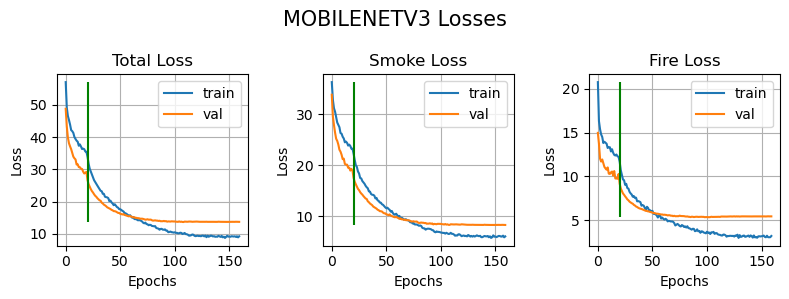

In [27]:
#plt.figure(figsize=(8,8))
fig, axs = plt.subplots(1,3, figsize=(8, 3))
fig.suptitle(MODEL + ' Losses', fontsize=15)

plt.subplot(1,3,1)
plt.plot(train_total_loss, label="train")
plt.plot(val_total_loss, label="val")
plt.title("Total Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.vlines(x=20, ymin=min(val_total_loss), ymax=max(train_total_loss), color='green')
plt.legend()
plt.grid()

plt.subplot(1,3,2)
plt.plot(train_smoke_loss, label="train")
plt.plot(val_smoke_loss, label="val")
plt.title("Smoke Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.vlines(x=20, ymin=min(val_smoke_loss), ymax=max(train_smoke_loss), color='green')
plt.legend()
plt.grid()

plt.subplot(1,3,3)
plt.plot(train_fire_loss, label="train")
plt.plot(val_fire_loss, label="val")
plt.title("Fire Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.vlines(x=20, ymin=min(val_fire_loss), ymax=max(train_fire_loss), color='green')
plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig(log_path + MODEL + "_losses.png")
plt.show()